<a href="https://colab.research.google.com/github/OliverAunan/Masteroppgave-2025/blob/main/Master2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


                       ORP     pH      EC  DO (mg/L)    Temp
Timestamp                                                   
2025-03-07 12:00:00  297.3  7.557  2138.0       8.22  20.719
2025-03-07 12:00:30  297.2  7.545  2139.0       8.29  20.719
2025-03-07 12:01:00  296.6  7.546  2136.0       8.05  20.719
2025-03-07 12:01:30  297.1  7.542  2138.0       8.22  20.717
2025-03-07 12:02:00  295.9  7.541  2133.0       8.26  20.723
2025-03-07 12:03:00  295.4  7.541  2133.0       8.06  20.721
2025-03-07 12:03:30  295.1  7.541  2133.0       7.99  20.724
2025-03-07 12:04:00  294.1  7.543  2131.0       8.02  20.723
2025-03-07 12:04:30  293.0  7.545  2131.0       7.91  20.723
2025-03-07 12:05:00  292.5  7.541  2131.0       7.96  20.720


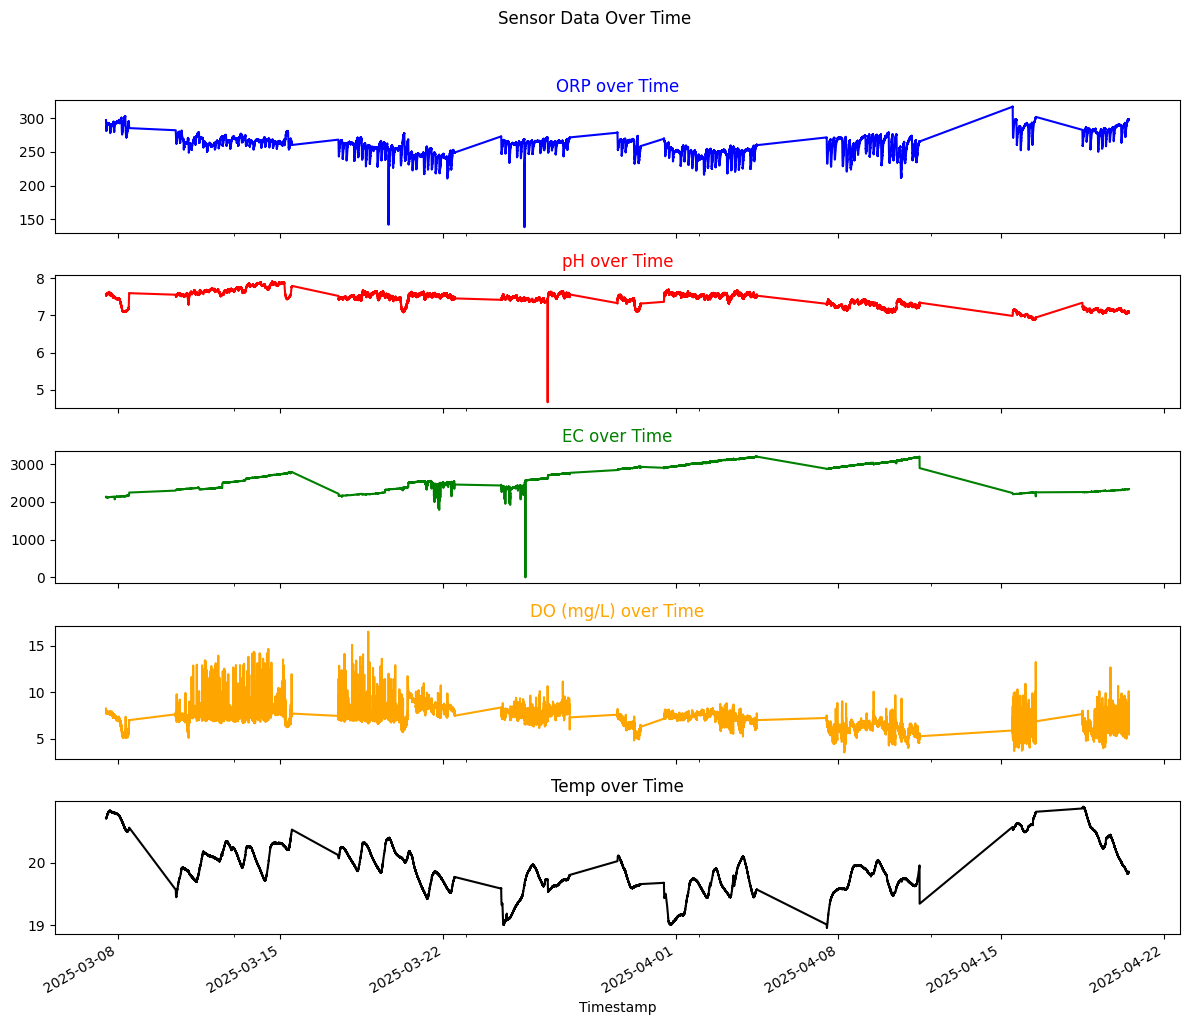

ORP          0
pH           0
EC           0
DO (mg/L)    0
Temp         0
dtype: int64


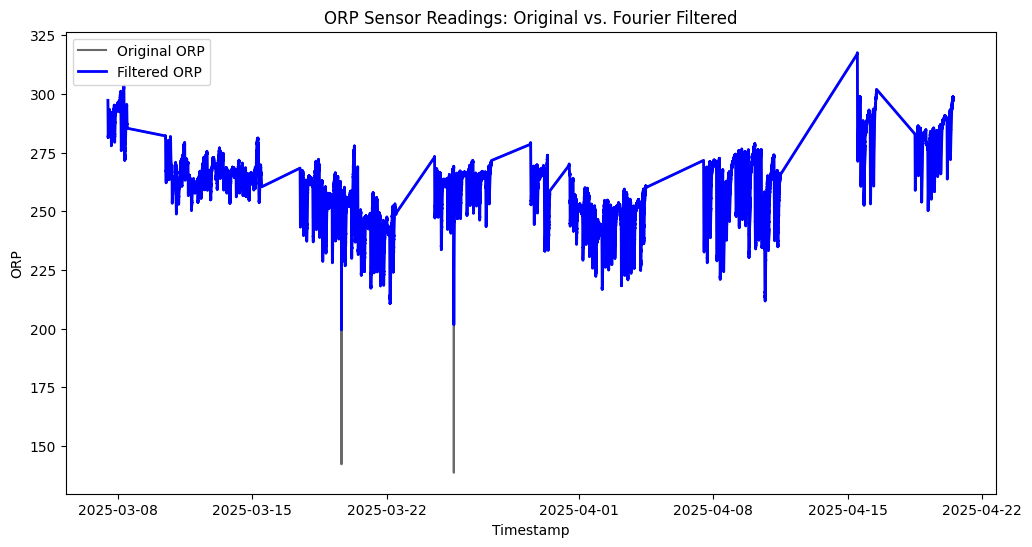

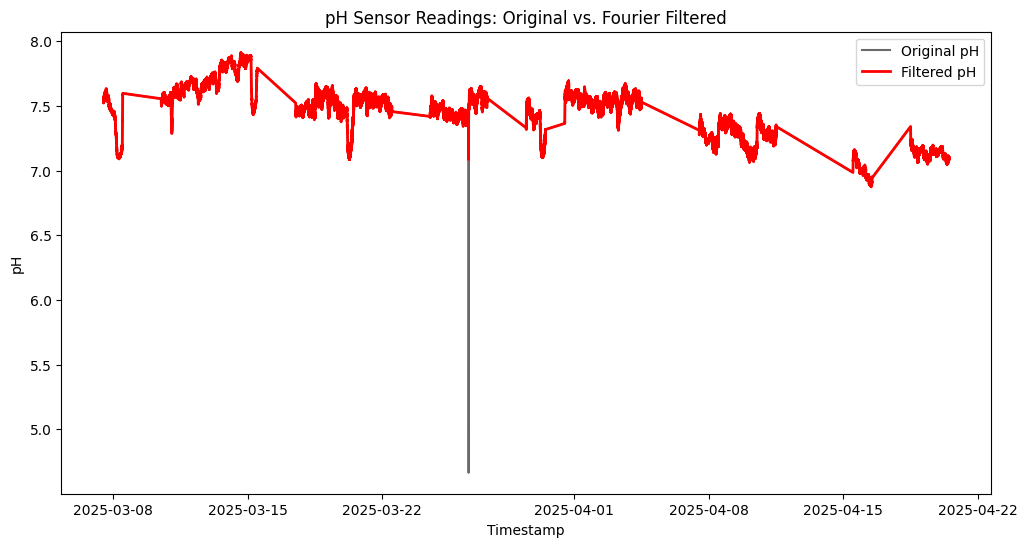

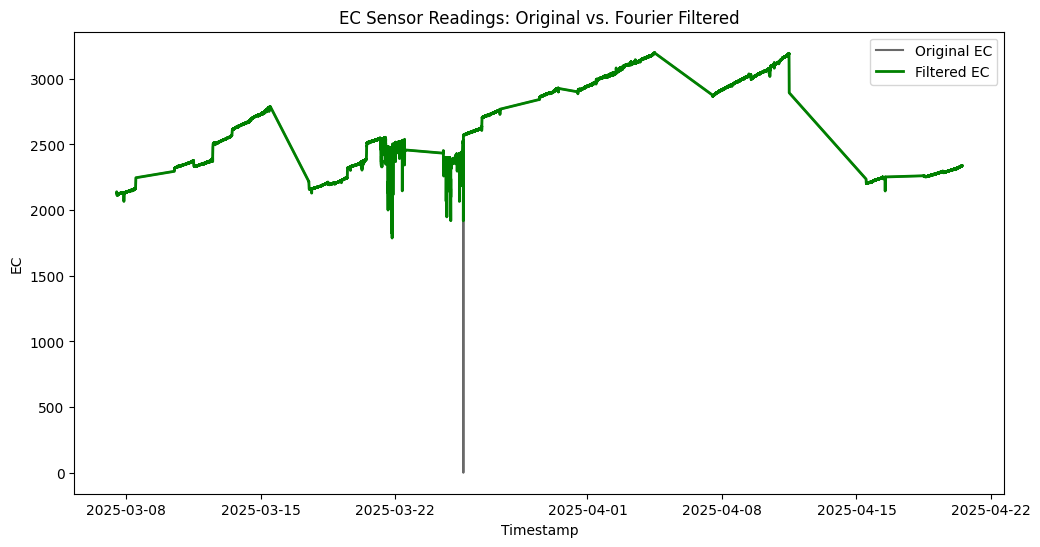

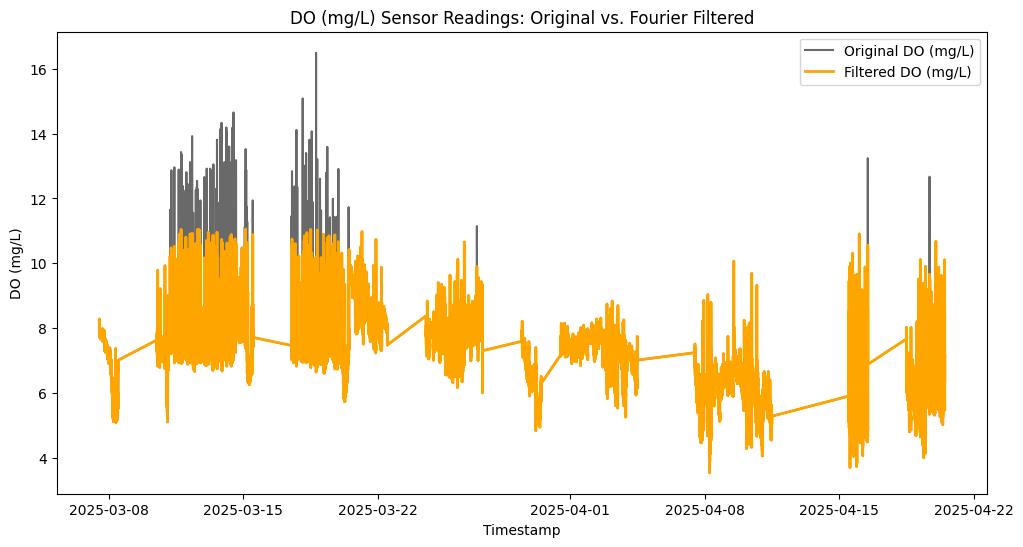

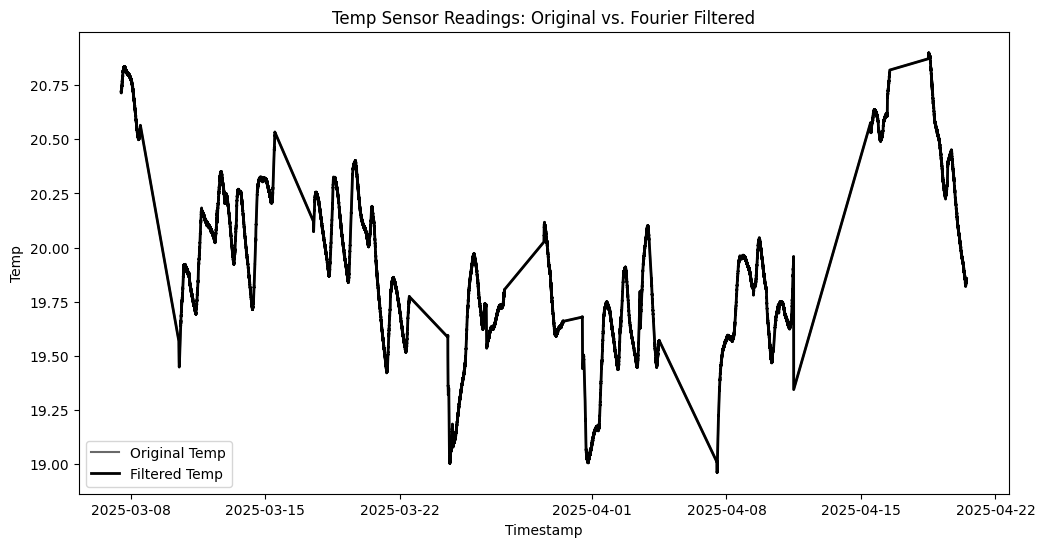

Sample spacing (seconds): 30.0


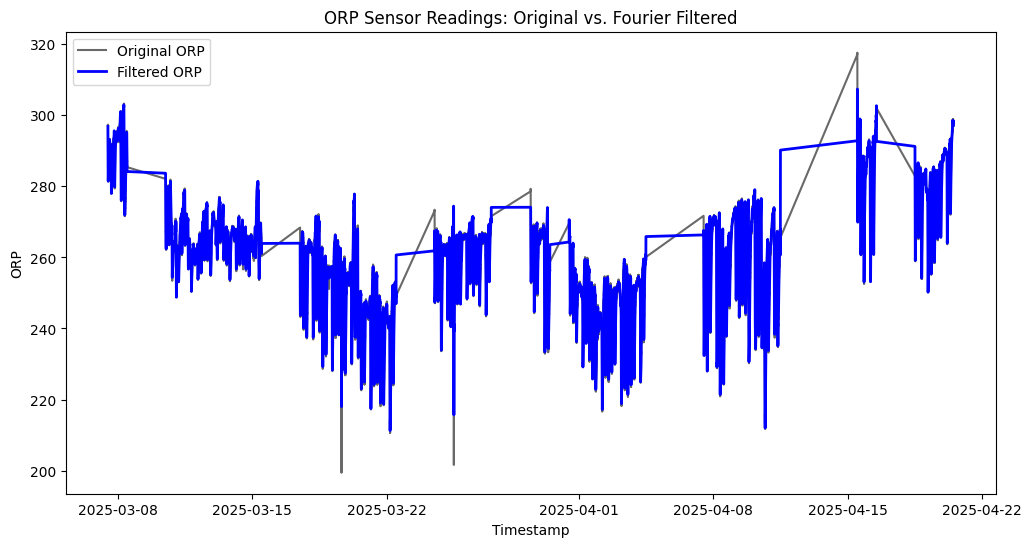

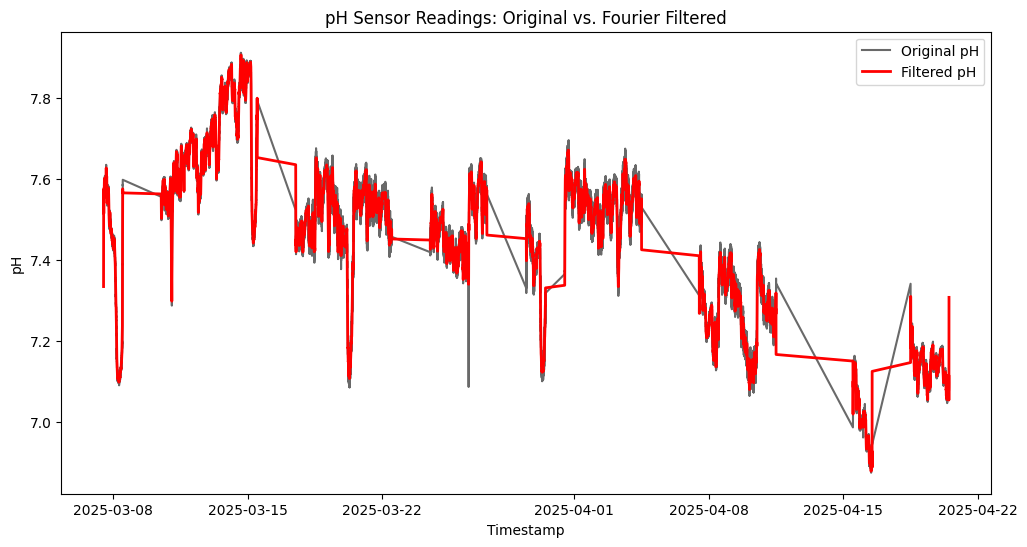

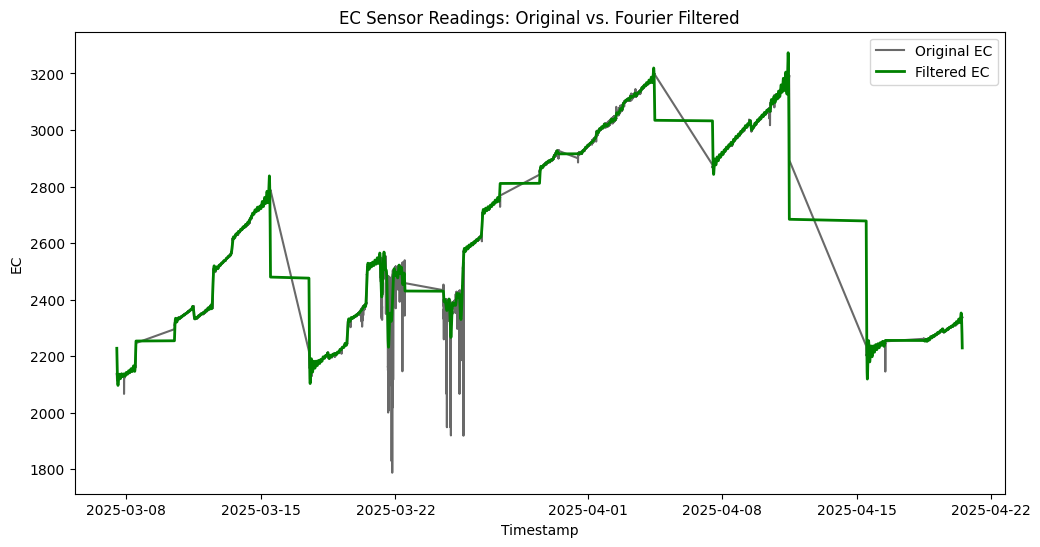

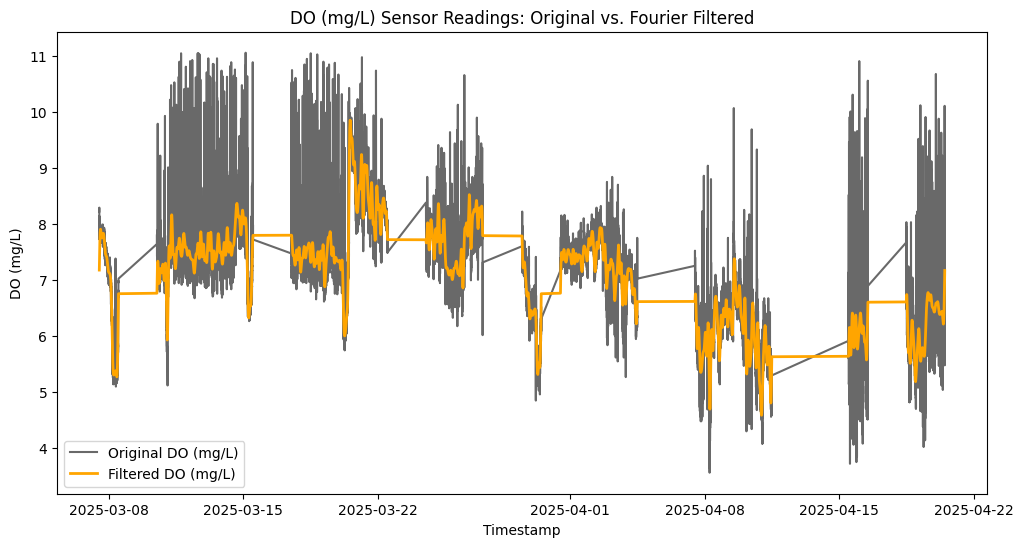

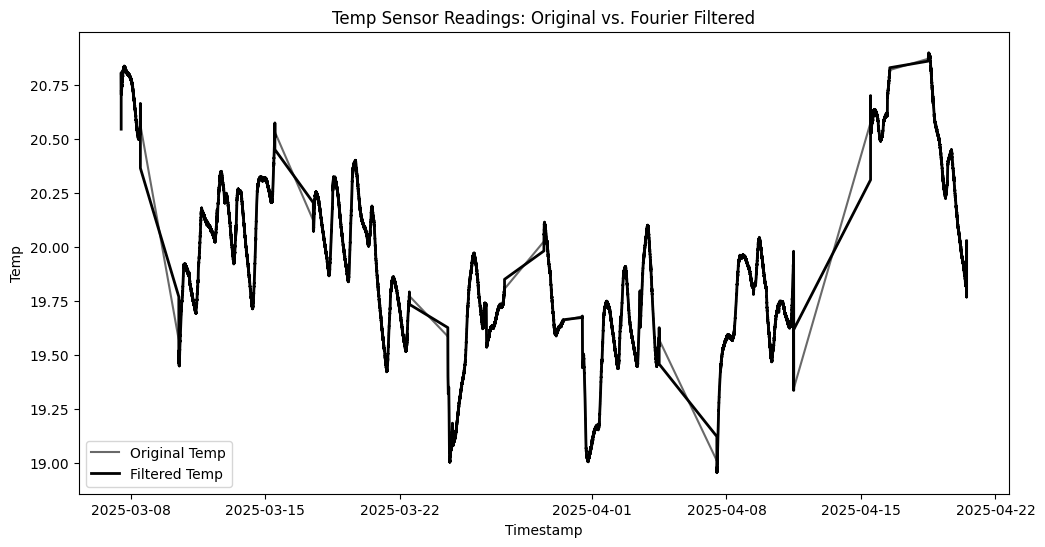

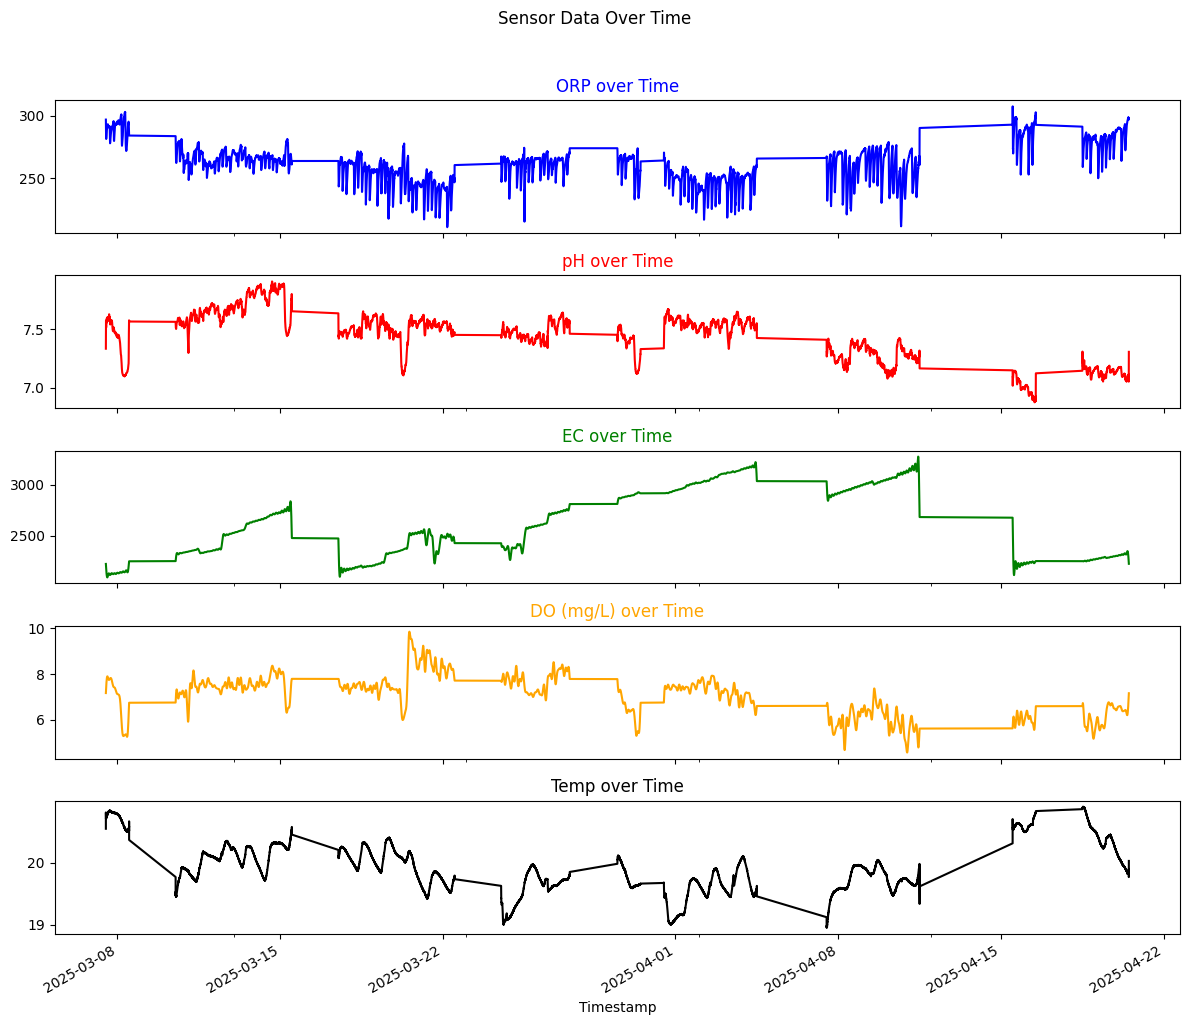

Original DOE columns: ['Date', 'RunOrder', 'Time', 'PtType', 'Flowrate', 'feed', 'bicarbonate', 'salt', 'Done']
DOE Data after selecting columns:
    Date      Time  Flowrate  feed  bicarbonate  salt
0   7.03  12:00:00       250     6            0     6
1  10.03  12:00:00       200     6            4     6
2  11.03  12:00:00       250     6            4     0
3  12.03  12:00:00       250     6            4    12
4  13.03  12:00:00       250     6            8     6
5  14.03  12:00:00       300     6            4     6
6  17.03  12:00:00       250    12            0     0
7  18.03  12:00:00       250    12            8     0
8  19.03  12:00:00       250    12            0    12
9  20.03  12:00:00       250    12            8    12
Processed DOE Data:
                     Flowrate  feed  bicarbonate  salt
Datetime                                              
2025-03-07 12:00:00       250     6            0     6
2025-03-10 12:00:00       200     6            4     6
2025-03-11 12:00:00 

In [ ]:
### Imports
import warnings
warnings.filterwarnings('ignore')

# Install SysIdentPy (run once)
!pip install sysidentpy
#!pip install --upgrade numpy pandas


import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
### Load dataset
import pandas as pd
import glob
import os
### Load in data

# Path to your directory containing the CSV files
csv_folder = '/content/drive/My Drive/Master data/Prediction_data'

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))

# Read each CSV file and store them in a list
dataframes = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=['Timestamp'])
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Sort the combined dataframe by Timestamp
combined_df.sort_values('Timestamp', inplace=True)

# 30 s offset fix
combined_df['offset_seconds'] = combined_df.groupby('Timestamp').cumcount() * 30
combined_df['Timestamp'] = combined_df['Timestamp'] + pd.to_timedelta(combined_df['offset_seconds'], unit='s')
combined_df = (
    combined_df
      .drop(columns=['offset_seconds'])
      .set_index('Timestamp')
      .sort_index()
)

# If duplicate timestamps exist, aggregate them by taking the mean
# combined_df = combined_df.groupby('Timestamp').mean()
# combined_df.index.name = 'Timestamp'

print(combined_df.head(10))
### Plot raw data
### plot raw data
# Define the desired color mapping for each sensor
sensor_colors = {
    'ORP': 'blue',
    'pH': 'red',
    'EC': 'green',
    'DO (mg/L)': 'orange',
    'Temp': 'black'
}

# Plot the data in subplots (this returns an array of axes)
axarr = combined_df.plot(subplots=True, figsize=(12, 10), legend=False)

# Loop through each axis and set the appropriate color and title.
for ax, col in zip(axarr, combined_df.columns):
    # Set the color of the plotted line (the first line in each axis)
    line = ax.get_lines()[0]
    line.set_color(sensor_colors.get(col, 'blue'))

    # Update the title to include the sensor name in the matching color.
    ax.set_title(f"{col} over Time", color=sensor_colors.get(col, 'blue'))

# Optionally, add an overall title
plt.suptitle("Sensor Data Over Time", y=1.02)
plt.tight_layout()
plt.show()
### NaN values and outlier removal
combined_df.dropna(inplace=True)
print(combined_df.isnull().sum())

# Make a copy so we don’t overwrite the original
df_clean = combined_df.copy()

sensors = ['ORP', 'pH', 'EC', 'DO (mg/L)', 'Temp']
### NaN values and outlier removal
# 1) Detect & remove outliers via Z‑score (>3)
for sensor in sensors:
    series = df_clean[sensor]
    z_scores = (series - series.mean()) / series.std()
    outliers = np.abs(z_scores) > 4
    df_clean.loc[outliers, sensor] = np.nan

    # 2) Interpolate missing values (time‑aware), then backfill leading NaNs
    df_clean[sensor].interpolate(method='time', inplace=True)
    df_clean[sensor].fillna(method='bfill', inplace=True)

for sensor in sensors:
    plt.figure(figsize=(12, 6))
    # Plot original data in darker gray
    plt.plot(combined_df.index, combined_df[sensor], label=f'Original {sensor}',
             color='dimgray', alpha=1.0)
    # Plot filtered data using the sensor-specific color
    plt.plot(df_clean.index, df_clean[sensor], label=f'Filtered {sensor}',
             color=sensor_colors[sensor], linewidth=2)
    plt.title(f'{sensor} Sensor Readings: Original vs. Fourier Filtered')
    plt.xlabel('Timestamp')
    plt.ylabel(sensor)
    plt.legend()
    plt.show()
### Filter data revmoving noise
### Filter data removing noise
def fourier_filter(signal, sample_spacing, cutoff):
    """
    Applies a low-pass Fourier filter to a 1D signal.

    Parameters:
      signal         : 1D array of data.
      sample_spacing : Time difference between samples in seconds.
      cutoff         : Frequencies higher than this value (in cycles per second) will be removed.

    Returns:
      filtered_signal: The filtered signal (real part after inverse FFT).
    """
    # Compute the FFT of the signal
    fft_signal = np.fft.fft(signal)
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(len(signal), d=sample_spacing)

    # Zero out frequencies higher than the cutoff
    fft_signal[np.abs(freqs) > cutoff] = 0

    # Compute the inverse FFT and return the real part
    filtered_signal = np.fft.ifft(fft_signal)
    return np.real(filtered_signal)

# Determine the sample spacing (in seconds) from the datetime index.
# (Assumes your index is sorted and evenly spaced.)
sample_spacing = (combined_df.index[1] - combined_df.index[0]).total_seconds()
print("Sample spacing (seconds):", sample_spacing)

# Define sensor columns and desired cutoff frequencies (in cycles per second).
# You'll need to adjust these cutoff frequencies based on your data characteristics.
cutoffs = {
    'ORP': 0.001,       # adjust as needed
    'pH': 0.001,        # adjust as needed
    'EC': 0.0001,        # adjust as needed; lower cutoff will smooth more noise
    'DO (mg/L)': 0.0001, # adjust as needed
    'Temp': 0.01       # adjust as needed
}

# Create a copy of the combined dataframe to hold filtered data.
filtered_df = df_clean.copy()

# Apply the Fourier filter to each sensor column.
for sensor in sensors:
    # Convert the sensor data to a numpy array
    data = df_clean[sensor].values
    filtered_data = fourier_filter(data, sample_spacing, cutoffs[sensor])
    filtered_df[sensor] = filtered_data



for sensor in sensors:
    plt.figure(figsize=(12, 6))
    # Plot original data in darker gray
    plt.plot(df_clean.index, df_clean[sensor], label=f'Original {sensor}',
             color='dimgray', alpha=1.0)
    # Plot filtered data using the sensor-specific color
    plt.plot(filtered_df.index, filtered_df[sensor], label=f'Filtered {sensor}',
             color=sensor_colors[sensor], linewidth=2)
    plt.title(f'{sensor} Sensor Readings: Original vs. Fourier Filtered')
    plt.xlabel('Timestamp')
    plt.ylabel(sensor)
    plt.legend()
    plt.show()
### Plot filtered data
### Plot filtered data
# Plot the data in subplots (this returns an array of axes)
axarr = filtered_df.plot(subplots=True, figsize=(12, 10), legend=False)

# Loop through each axis and set the appropriate color and title.
for ax, col in zip(axarr, filtered_df.columns):
    # Set the color of the plotted line (the first line in each axis)
    line = ax.get_lines()[0]
    line.set_color(sensor_colors.get(col, 'blue'))

    # Update the title to include the sensor name in the matching color.
    ax.set_title(f"{col} over Time", color=sensor_colors.get(col, 'blue'))

# Optionally, add an overall title
plt.suptitle("Sensor Data Over Time", y=1.02)
plt.tight_layout()
plt.show()
### Load in DOE
# --- Load the DOE Excel File ---
doe_path  = '/content/drive/My Drive/Master data/doe_testset.xlsx'

# Skip only the first row, so that row 1 becomes the header row.
df_doe = pd.read_excel("/content/drive/My Drive/Master data/doe_testset.xlsx", skiprows=2)

# Inspect the columns to verify that the header is read correctly.
print("Original DOE columns:", df_doe.columns.tolist())

# Optionally, drop completely empty rows
df_doe.dropna(how='all', inplace=True)

# Now, keep only the columns you need.
cols_to_keep = ['Date', 'Time', 'Flowrate', 'feed', 'bicarbonate', 'salt']
df_doe = df_doe[cols_to_keep]

# Print a few rows to check that you have all DOE events (including 6.03 and 7.03)
print("DOE Data after selecting columns:")
print(df_doe.head(10))

# --- Prepare the Data for DateTime Conversion ---
# Ensure the 'Time' column is converted to string format.
df_doe['Time'] = df_doe['Time'].apply(lambda x: x.strftime('%H:%M:%S') if hasattr(x, 'strftime') else str(x))

# Add a 'Year' column (assuming the year is 2025)
df_doe['Year'] = 2025

# Create a new datetime column by combining 'Date', 'Year', and 'Time'
# Here we assume 'Date' is in the format "6.03" meaning "6th of March".
df_doe['Datetime'] = pd.to_datetime(
    df_doe['Date'].astype(str) + '.' + df_doe['Year'].astype(str) + ' ' + df_doe['Time'],
    format='%d.%m.%Y %H:%M:%S'
)

# Drop the original Date, Time, and Year columns, as they are no longer needed.
df_doe.drop(columns=['Date', 'Time', 'Year'], inplace=True)

# Set the new Datetime as the index and sort the DataFrame.
df_doe.set_index('Datetime', inplace=True)
df_doe.sort_index(inplace=True)

print("Processed DOE Data:")
print(df_doe)
# --- Ensure your sensor data (filtered_df) is sorted by its datetime index:
combined_df.sort_index(inplace=True)

# Compute seconds since the very first timestamp
first_ts = combined_df.index[0]
combined_df['Time elapsed'] = (combined_df.index - first_ts).total_seconds()

# Reorder so 'Seconds_since_start' comes first (right after the index)
cols = combined_df.columns.tolist()
cols.remove('Time elapsed')
combined_df = combined_df[['Time elapsed'] + cols]

# --- Reset your DOE DataFrame's index to get a column with the DOE timestamp,
# and rename it to 'DOE_time' (if your processed DOE DataFrame currently uses the index "Datetime")
df_doe_reset = df_doe.reset_index().rename(columns={'Datetime': 'DOE_time'})
df_doe_reset['DOE_time'] = pd.to_datetime(df_doe_reset['DOE_time'])

# --- Merge using merge_asof with direction='backward'
merged_df = pd.merge_asof(
    combined_df,
    df_doe_reset.sort_values('DOE_time'),
    left_index=True,
    right_on='DOE_time',
    direction='backward'
)

# For debugging, check that the merge worked:
print("Merged DataFrame columns:")
print(merged_df.columns.tolist())
print("First few rows of merged_df:")
print(merged_df.head(10))
from datetime import date, time
# Step 1: Compute Elapsed Time from DOE Event (in minutes)
# ------------------------------------------------------------
# This computes time_diff for each row as the difference between the sensor timestamp
# and the DOE event time that was merged in.
merged_df['time_diff'] = (merged_df.index.to_series() - merged_df['DOE_time']).dt.total_seconds()

# ------------------------------------------------------------
# Step 2: Compute Effective Dosing Features Using np.where Conditions
# ------------------------------------------------------------
# Bicarbonate effect: 30 seconds)
merged_df['bicarbonate_effect'] = np.where(
    (merged_df['time_diff'] >= 0) & (merged_df['time_diff'] <= 180),
    merged_df['bicarbonate'],
    np.nan
)

# Salt effect: active for 30 seconds
merged_df['salt_effect'] = np.where(
    (merged_df['time_diff'] >= 0) & (merged_df['time_diff'] <= 180),
    merged_df['salt'],
    np.nan
)

# Flowrate effect: active for all the time
merged_df['flowrate_effect'] = merged_df['Flowrate']

def compute_feed_effect(row):
    sensor_ts = row.name            # Timestamp index
    feed_value = row['feed']        # DOE feed amount
    d = sensor_ts.date()            # extract date

    # Choose feed hours based on date window
    if date(2025, 3, 30) <= d <= date(2025, 4, 4):
        feeding_hours = [5, 9, 13, 17, 21]
    else:
        feeding_hours = [4, 8, 12, 16, 20]

    # 5-minute feeding window at each hour
    for h in feeding_hours:
        window_start = pd.Timestamp.combine(d, time(h, 0))
        window_end   = window_start + pd.Timedelta(minutes=6)
        if window_start <= sensor_ts < window_end:
            return feed_value

    return np.nan   # will be filled with 0 later

merged_df['feed_effect'] = merged_df.apply(compute_feed_effect, axis=1)

# List of raw DOE columns to drop:
raw_doe_cols = ['feed', 'bicarbonate', 'salt', 'Flowrate', 'DOE_time', 'time_diff']
merged_df.drop(columns=raw_doe_cols, inplace=True)

# Reorder columns so that dosing effects come first:
dosing_effect_cols = ['Time elapsed','feed_effect', 'bicarbonate_effect', 'salt_effect', 'flowrate_effect']
remaining_cols = [col for col in merged_df.columns if col not in dosing_effect_cols]
merged_df = merged_df[dosing_effect_cols + remaining_cols]

print("Final Merged DataFrame with Effective Dosing Features (first 10 rows):")
print(merged_df.head(10))
effective_cols = ['feed_effect', 'bicarbonate_effect', 'salt_effect', 'flowrate_effect']
merged_df[effective_cols] = merged_df[effective_cols].fillna(0)
print(merged_df)

merged_df.rename(columns={'DO (mg/L)': 'DO'}, inplace=True)

In [ ]:
merged_df = (
    merged_df
      .set_index('Time elapsed')
      .sort_index()
)
merged_df

feed_effect  bicarbonate_effect  salt_effect  flowrate_effect  \
Time elapsed                                                                  
0.0                   6.0                 0.0          6.0              250   
30.0                  6.0                 0.0          6.0              250   
60.0                  6.0                 0.0          6.0              250   
90.0                  6.0                 0.0          6.0              250   
120.0                 6.0                 0.0          6.0              250   
...                   ...                 ...          ...              ...   
3801420.0             0.0                 0.0          0.0              300   
3801450.0             0.0                 0.0          0.0              300   
3801480.0             0.0                 0.0          0.0              300   
3801510.0             0.0                 0.0          0.0              300   
3801540.0             0.0                 0.0          0.0              300   

                ORP     pH      EC    DO    Temp  
Time elapsed                                      
0.0           297.3  7.557  2138.0  8.22  20.719  
30.0          297.2  7.545  2139.0  8.29  20.719  
60.0          296.6  7.546  2136.0  8.05  20.719  
90.0          297.1  7.542  2138.0  8.22  20.717  
120.0         295.9  7.541  2133.0  8.26  20.723  
...             ...    ...     ...   ...     ...  
3801420.0     297.4  7.090  2337.0  5.98  19.852  
3801450.0     297.4  7.092  2337.0  6.58  19.853  
3801480.0     297.3  7.090  2336.0  7.22  19.857  
3801510.0     297.8  7.098  2335.0  6.32  19.857  
3801540.0     297.3  7.085  2337.0  8.40  19.855  

[69919 rows x 9 columns]

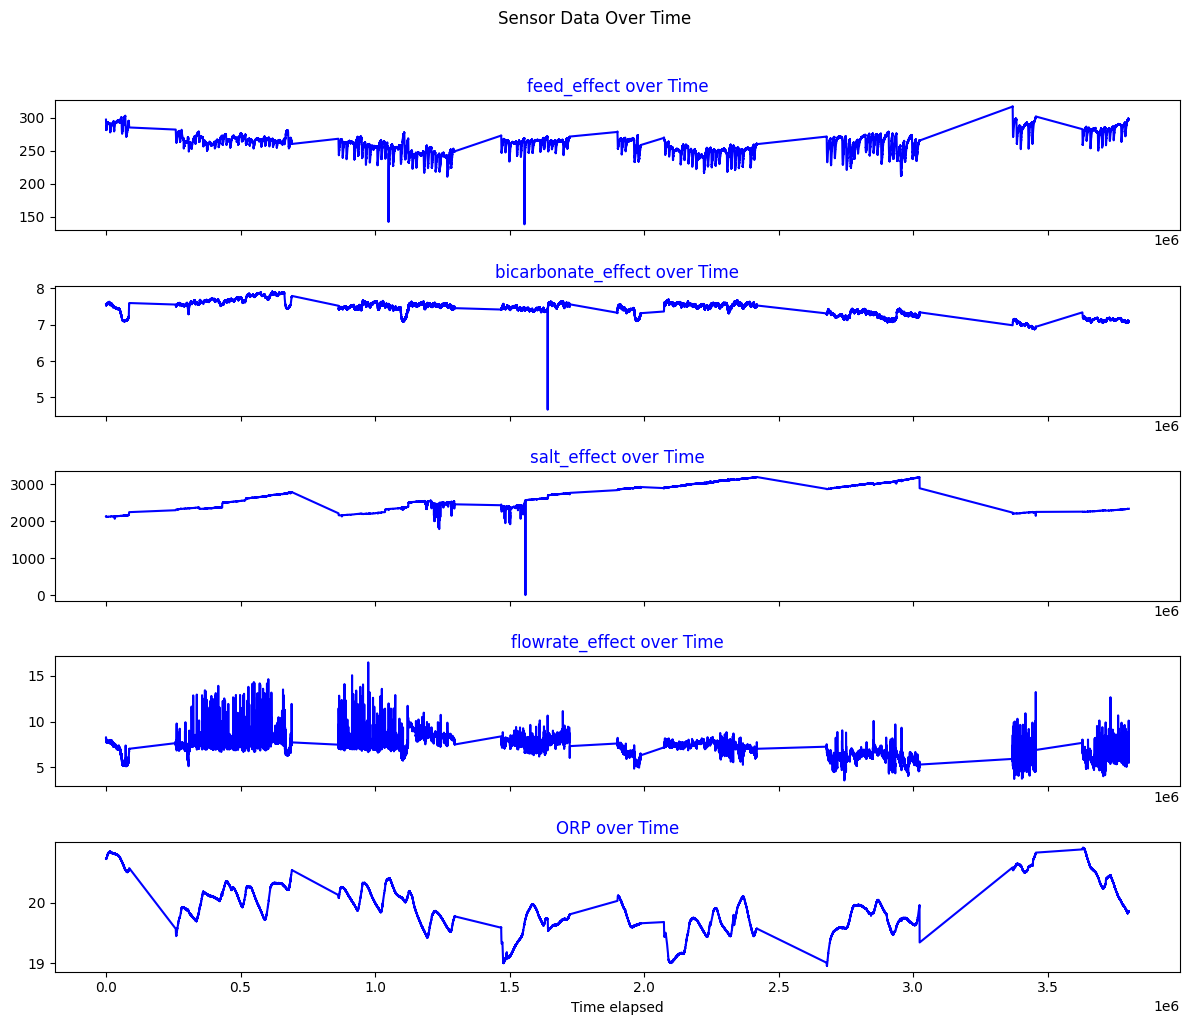

In [ ]:
sensors = ["ORP","pH","EC","DO","Temp"]

# Plot the data in subplots (this returns an array of axes)
axarr = merged_df[sensors].plot(subplots=True, figsize=(12, 10), legend=False)

# Loop through each axis and set the appropriate color and title.
for ax, col in zip(axarr, merged_df.columns):
    # Set the color of the plotted line (the first line in each axis)
    line = ax.get_lines()[0]
    line.set_color(sensor_colors.get(col, 'blue'))

    # Update the title to include the sensor name in the matching color.
    ax.set_title(f"{col} over Time", color=sensor_colors.get(col, 'blue'))

# Optionally, add an overall title
plt.suptitle("Sensor Data Over Time", y=1.02)
plt.tight_layout()
plt.show()

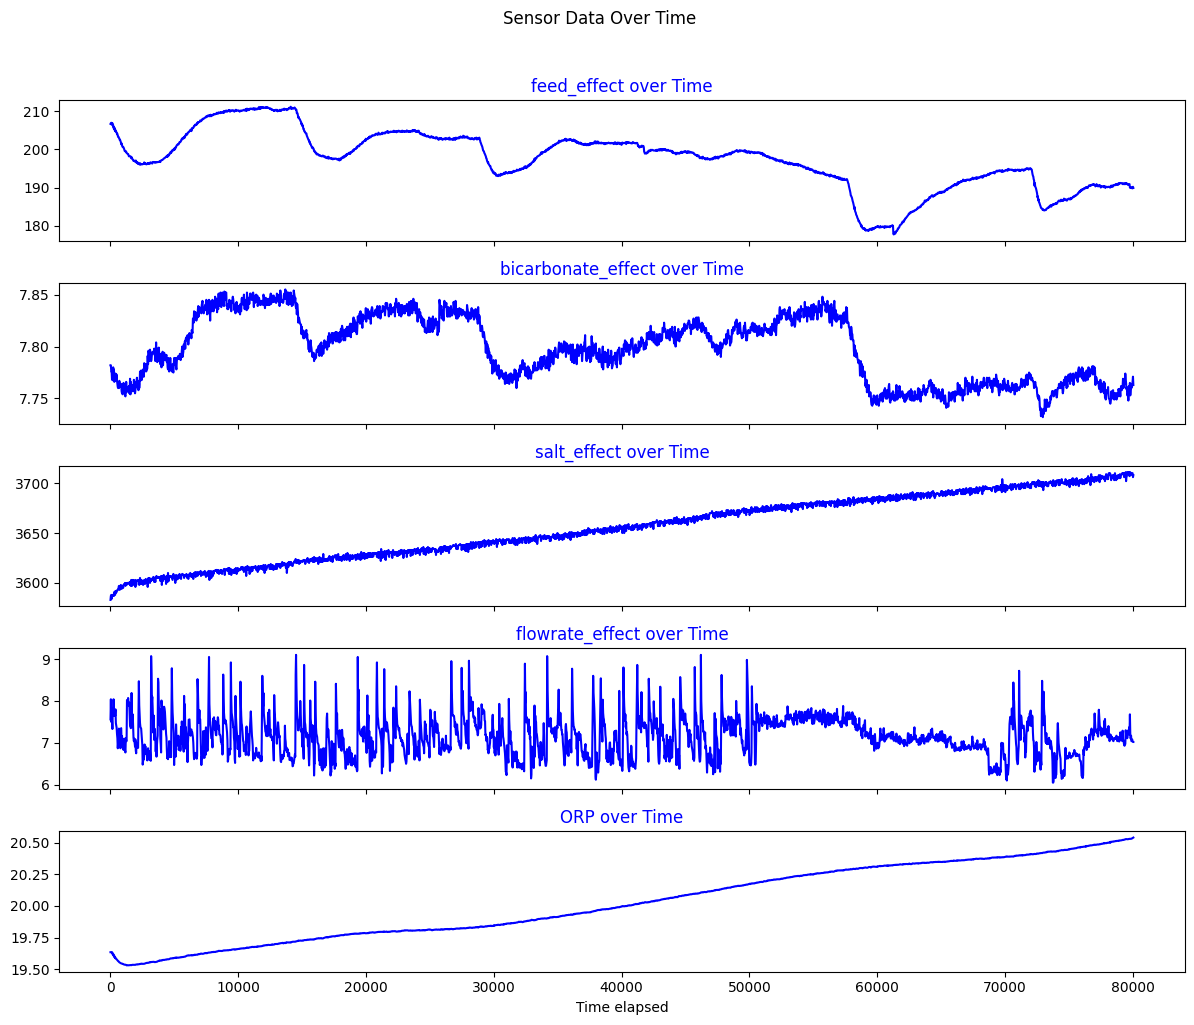

In [ ]:
### Load in Validation data
# --- Load the Validation data ---
validation_path  = '/content/drive/My Drive/Master data/Validation_data_unfileterd.csv'

# Skip only the first row, so that row 1 becomes the header row.
df_validation = pd.read_csv("/content/drive/My Drive/Master data/Validation_data_unfiltered.csv")


df_validation.rename(columns={'DO (mg/L)': 'DO'}, inplace=True)

## Set Time elapsed as index
df_validation = (
    df_validation
      .set_index('Time elapsed')
      .sort_index()
)

df_validation
# Plot the data in subplots (this returns an array of axes)
axarr = df_validation[sensors].plot(subplots=True, figsize=(12, 10), legend=False)

# Loop through each axis and set the appropriate color and title.
for ax, col in zip(axarr, df_validation.columns):
    # Set the color of the plotted line (the first line in each axis)
    line = ax.get_lines()[0]
    line.set_color(sensor_colors.get(col, 'blue'))

    # Update the title to include the sensor name in the matching color.
    ax.set_title(f"{col} over Time", color=sensor_colors.get(col, 'blue'))

# Optionally, add an overall title
plt.suptitle("Sensor Data Over Time", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
df_validation

feed_effect  bicarbonate_effect  salt_effect  flowrate_effect  \
Time elapsed                                                                  
0.0                   9.0                 2.0         10.0              225   
30.0                  9.0                 2.0         10.0              225   
60.0                  9.0                 0.0          0.0              225   
90.0                  9.0                 0.0          0.0              225   
120.0                 9.0                 0.0          0.0              225   
...                   ...                 ...          ...              ...   
79920.0               0.0                 0.0          0.0              225   
79950.0               0.0                 0.0          0.0              225   
79980.0               0.0                 0.0          0.0              225   
80010.0               0.0                 0.0          0.0              225   
80040.0               0.0                 0.0          0.0              225   

                ORP     pH      EC    DO    Temp  
Time elapsed                                      
0.0           206.7  7.782  3583.0  7.56  19.634  
30.0          206.9  7.782  3587.0  8.04  19.634  
60.0          207.0  7.776  3588.0  7.50  19.634  
90.0          206.9  7.776  3584.0  7.60  19.635  
120.0         206.5  7.768  3588.0  7.53  19.625  
...             ...    ...     ...   ...     ...  
79920.0       189.9  7.764  3710.0  7.05  20.533  
79950.0       189.8  7.762  3710.0  7.08  20.536  
79980.0       190.0  7.767  3710.0  7.03  20.538  
80010.0       190.2  7.771  3706.0  7.02  20.539  
80040.0       189.9  7.763  3708.0  7.02  20.541  

[2503 rows x 9 columns]

Device: cuda
Total rows : 69,919
Train tensors : (55695, 240, 9) (55695, 4)
Epoch   0  val=0.2396
Epoch   1  val=0.1127
Epoch   2  val=0.0864
Epoch   3  val=0.0756
Epoch   4  val=0.0744
Epoch   5  val=0.0722
Epoch   6  val=0.0674
Epoch   7  val=0.0611
Epoch   8  val=0.0575
Epoch   9  val=0.0567
Epoch  10  val=0.0594
Epoch  11  val=0.0418
Epoch  12  val=0.0405
Epoch  13  val=0.0395
Epoch  14  val=0.0392
Epoch  15  val=0.0337
Epoch  16  val=0.0391
Epoch  17  val=0.0302
Epoch  18  val=0.0348
Epoch  19  val=0.0364
Epoch  20  val=0.0345
Epoch  21  val=0.0468
Epoch  22  val=0.0294
Epoch  23  val=0.0348
Epoch  24  val=0.0247
Epoch  25  val=0.0480
Epoch  26  val=0.0296
Epoch  27  val=0.0276
Epoch  28  val=0.0318
Epoch  29  val=0.0249
Epoch  30  val=0.0200
Epoch  31  val=0.0212
Epoch  32  val=0.0198
Epoch  33  val=0.0326
Epoch  34  val=0.0181
Epoch  35  val=0.0206
Epoch  36  val=0.0185
Epoch  37  val=0.0204
Epoch  38  val=0.0349
Epoch  39  val=0.0252
Epoch  40  val=0.0457
Epoch  41  val=0.0226


Forecast: 100%|██████████| 240/240 [00:00<00:00, 771.80it/s]


RMSE (1 h)  [pH, EC, DO] : 8.866501878087565


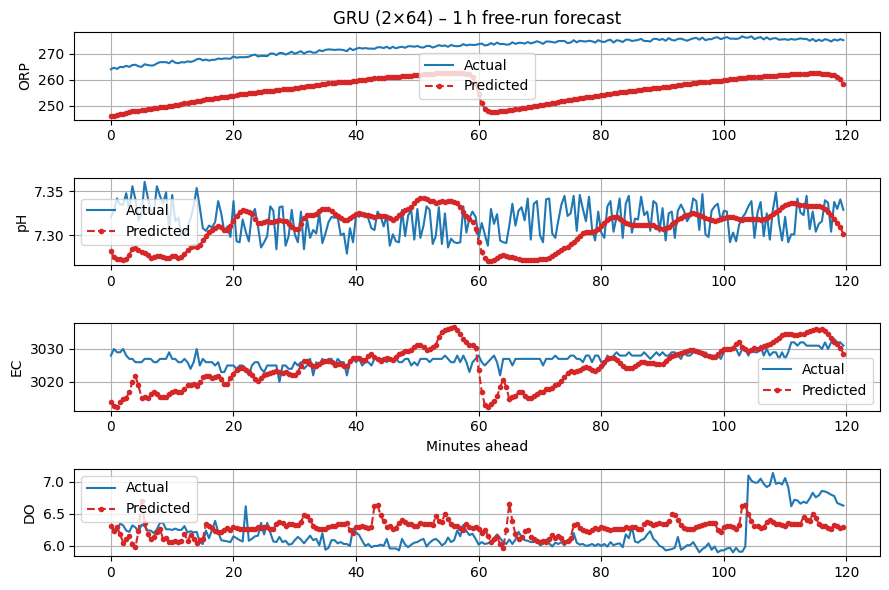

In [ ]:
"""
narx_gru_gpu.py
---------------
• chronological 80 % / 20 % split
• 2 h history  (240 steps @ 30 s)  — inputs *and* outputs
• GRU( input=7, hidden=64, layers=2 ) → Linear(3)
• 1 h (120‑step) free‑run forecast on RTX 4060 (or CPU fallback)
"""
import os, warnings
os.environ["OMP_NUM_THREADS"] = "8"
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ── helper: build GRU input tensors ───────────────────────────────────
def build_sequences(Xu, Yu, seq_len):
    """Return Xseq (N, T, 7) and Y (N, 3) aligned."""
    n = len(Xu) - seq_len
    feats = np.concatenate([Xu, Yu], axis=1)      # 7 features
    Xseq  = np.empty((n, seq_len, feats.shape[1]))
    for t in range(seq_len):
        Xseq[:, t, :] = feats[t : t+n]
        feats = np.roll(feats, -1, axis=0)        # shift once
    Ytar = Yu[seq_len:]
    return Xseq.astype("float32"), Ytar.astype("float32")

# ── 1 · load CSV -------------------------------------------------------
df = merged_df.copy()

x_cols = ["feed_effect","bicarbonate_effect","salt_effect","flowrate_effect","Temp"]
y_cols = ["ORP","pH","EC","DO"]
X_all, Y_all = df[x_cols].values, df[y_cols].values
print(f"Total rows : {len(df):,}")

# ── 2 · split & scale --------------------------------------------------
X_tr, X_te, Y_tr, Y_te = train_test_split(
    X_all, Y_all, test_size=0.20, shuffle=False)
sx, sy = StandardScaler(), StandardScaler()
X_tr_s, Y_tr_s = sx.fit_transform(X_tr), sy.fit_transform(Y_tr)
X_te_s, Y_te_s = sx.transform(X_te),     sy.transform(Y_te)

SEQ   = 240            # 2 h Beste 240
HORIZ = 240            # 1 h forecast Beste 120 val=0.0022
assert len(X_te_s) > SEQ + HORIZ, "Test set too small for chosen horizon."

Xseq_tr, Y_tr_t = build_sequences(X_tr_s, Y_tr_s, SEQ)
Xseq_te, Y_te_t = build_sequences(X_te_s, Y_te_s, SEQ)
print("Train tensors :", Xseq_tr.shape, Y_tr_t.shape)

# ── 3 · DataLoaders ----------------------------------------------------
train_ds = TensorDataset(torch.from_numpy(Xseq_tr),
                         torch.from_numpy(Y_tr_t))
val_len  = int(0.1*len(train_ds))
train_ds, val_ds = random_split(train_ds, [len(train_ds)-val_len, val_len],
                                generator=torch.Generator().manual_seed(0))

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=512)

# ── 4 · GRU network ----------------------------------------------------
class GRUNet(nn.Module):
    def __init__(self, feat=9, hidden=128, layers=3, out=4):
        super().__init__()
        self.gru = nn.GRU(feat, hidden, layers, batch_first=True, dropout=0.2)
        self.fc  = nn.Linear(hidden, out)
    def forward(self, x):
        _, h = self.gru(x)        # h: (layers, batch, hidden)
        return self.fc(h[-1])     # last layer's hidden state

net = GRUNet().to(device)
opt = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,factor=0.5,patience=5)

# ── 5 · Training with early stopping ----------------------------------
best_val = np.inf; patience=20; stall=0
for epoch in range(500):
    net.train()
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad(); loss_fn(net(xb), yb).backward(); opt.step()
    # validation
    net.eval(); val_loss=0; n=0
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(net(xb), yb).item()*len(xb); n+=len(xb)
    val_loss/=n; scheduler.step(val_loss)
    print(f"Epoch {epoch:3d}  val={val_loss:.4f}")
    if val_loss < best_val - 1e-5:
        best_val = val_loss; stall = 0
        best_state = net.state_dict()
    else:
        stall += 1
    if stall >= patience:
        print("Early‑stop at epoch", epoch); break
net.load_state_dict(best_state)

# ── 6 · free‑run 1‑hour forecast --------------------------------------
hist_in  = torch.tensor(X_te_s[:SEQ], dtype=torch.float32, device=device)
hist_out = torch.tensor(Y_te_s[:SEQ], dtype=torch.float32, device=device)
pred_scaled=[]
net.eval()
with torch.no_grad():
    for _ in tqdm(range(HORIZ), desc="Forecast"):
        seq = torch.cat([hist_in, hist_out], dim=1).unsqueeze(0)  # (1,240,7)
        y_hat = net(seq).squeeze(0)                               # (3,) on GPU
        pred_scaled.append(y_hat.cpu().numpy())

        # append the latest input row (held constant here) and predicted output
        new_in  = torch.tensor(X_te_s[SEQ], device=device, dtype=torch.float32)
        hist_in  = torch.vstack([hist_in,  new_in])[-SEQ:]
        hist_out = torch.vstack([hist_out, y_hat])[-SEQ:]


y_pred = sy.inverse_transform(np.vstack(pred_scaled))
actual = sy.inverse_transform(Y_te_s[SEQ:SEQ+HORIZ])
rmse   = np.sqrt(mean_squared_error(actual, y_pred))
print("RMSE (1 h)  [pH, EC, DO] :", rmse)

# ── 7 · plot -----------------------------------------------------------
mins = np.arange(HORIZ)*0.5
plt.figure(figsize=(9,6))
for j,var in enumerate(y_cols):
    ax=plt.subplot(4,1,j+1)
    ax.plot(mins, actual[:,j], label="Actual", c="tab:blue")
    ax.plot(mins, y_pred[:,j], '--o', ms=3, label="Predicted", c="tab:red")
    ax.set_ylabel(var); ax.grid(True)
    if j==0: ax.set_title("GRU (2×64) – 1 h free‑run forecast")
    if j==2: ax.set_xlabel("Minutes ahead")
    ax.legend()
plt.tight_layout(); plt.show()

Validation tensors: Xseq=(2263, 240, 9), Y_t=(2263, 4)


Val Forecast: 100%|██████████| 240/240 [00:00<00:00, 584.70it/s]


Validation RMSE [ORP, pH, EC, DO]: 172.07171801762854
ORP RMSE: 4.4415
pH RMSE: 0.1718
EC RMSE: 344.1143
DO RMSE: 0.5747


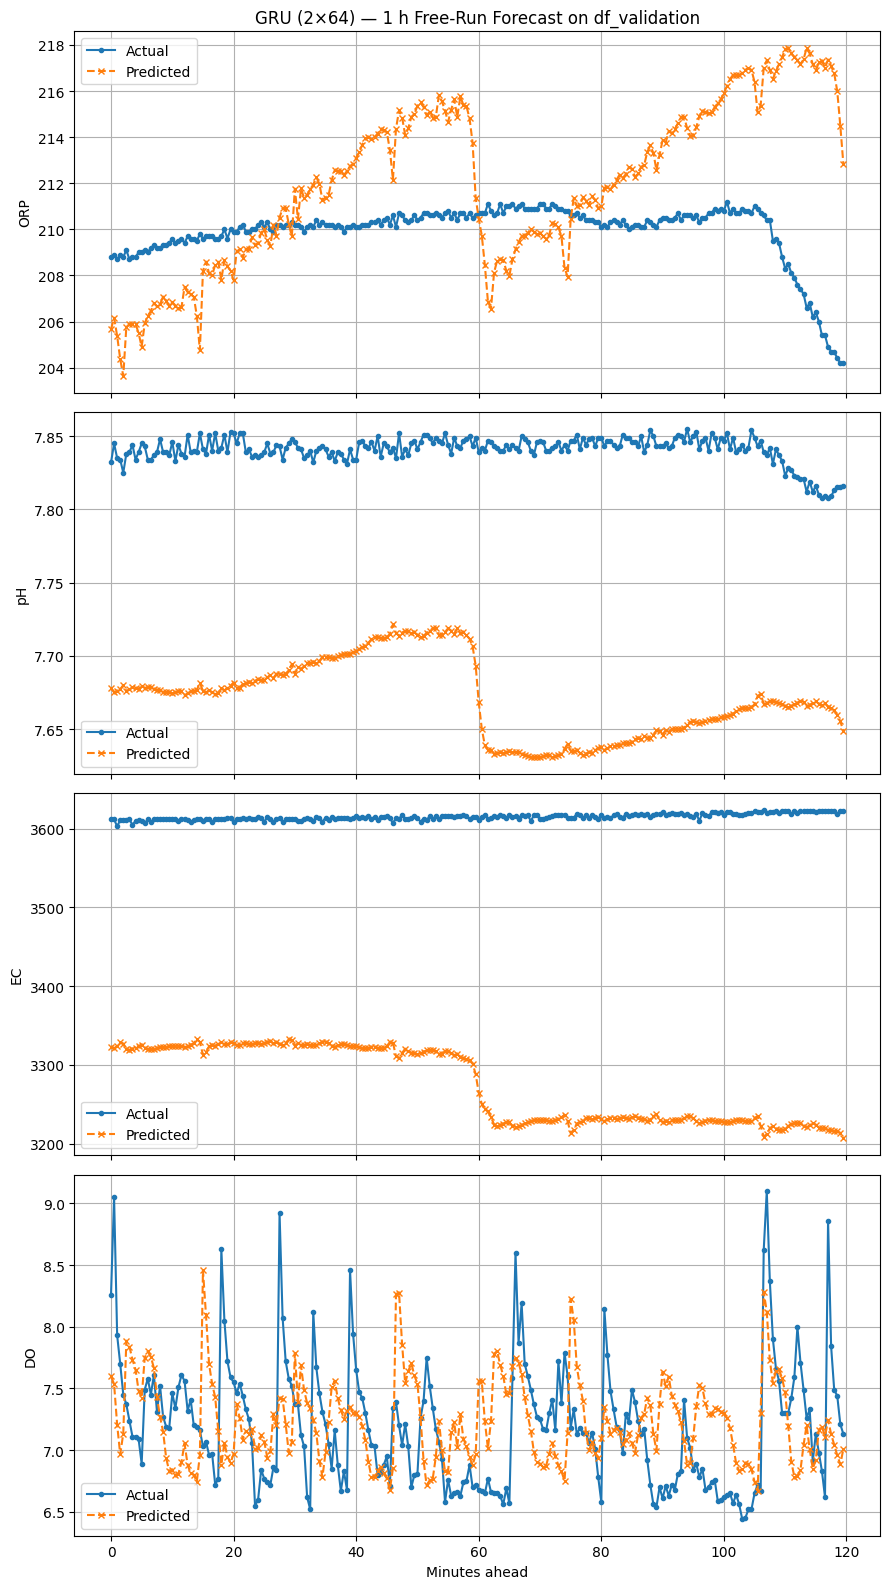

In [ ]:
# ── A · Prepare validation set ─────────────────────────────────────────
# ensure df_validation has the same columns as merged_df
df_val = df_validation.copy()

# 1. extract X_val, Y_val
X_val, Y_val = df_val[x_cols].values, df_val[y_cols].values

# 2. scale using your existing scalers
X_val_s = sx.transform(X_val)    # sx was fit on X_tr
Y_val_s = sy.transform(Y_val)    # sy was fit on Y_tr

# 3. build sequences (need at least SEQ + HORIZ rows)
assert len(X_val_s) > SEQ + HORIZ, "Validation set too small for chosen horizon."
Xseq_val, Y_val_t = build_sequences(X_val_s, Y_val_s, SEQ)
print(f"Validation tensors: Xseq={Xseq_val.shape}, Y_t={Y_val_t.shape}")

# ── B · 1-hour free-run forecast on validation ─────────────────────────
# start with the first SEQ rows of val as your “history in”
hist_in  = torch.tensor(X_val_s[:SEQ], dtype=torch.float32, device=device)
hist_out = torch.tensor(Y_val_s[:SEQ], dtype=torch.float32, device=device)

pred_scaled_val = []
net.eval()
with torch.no_grad():
    for _ in tqdm(range(HORIZ), desc="Val Forecast"):
        seq = torch.cat([hist_in, hist_out], dim=1).unsqueeze(0)  # (1,SEQ,7)
        y_hat = net(seq).squeeze(0)                               # (4,)
        pred_scaled_val.append(y_hat.cpu().numpy())

        # roll forward: drop oldest and append newest rows
        new_in   = torch.tensor(X_val_s[SEQ],    device=device, dtype=torch.float32)
        hist_in   = torch.vstack([hist_in,  new_in])[-SEQ:]
        hist_out  = torch.vstack([hist_out, y_hat])   [-SEQ:]

# stack & inverse-scale
y_pred_val = sy.inverse_transform(np.vstack(pred_scaled_val))   # (HORIZ,4)
actual_val = sy.inverse_transform(Y_val_s[SEQ:SEQ+HORIZ])        # (HORIZ,4)

# compute RMSE
rmse_val = np.sqrt(mean_squared_error(actual_val, y_pred_val))
print("Validation RMSE [ORP, pH, EC, DO]:", rmse_val)

# --- compute per-sensor RMSE ---
# multioutput='raw_values' gives one MSE per column
mse_vals = mean_squared_error(
    actual_val,
    y_pred_val,
    multioutput='raw_values'
)
rmse_vals = np.sqrt(mse_vals)

# print them out
for sensor, rmse in zip(y_cols, rmse_vals):
    print(f"{sensor} RMSE: {rmse:.4f}")

# ── C · Plot predicted vs. actual ───────────────────────────────────────
import matplotlib.pyplot as plt
mins = np.arange(HORIZ)*0.5  # 0.5-min increments

fig, axes = plt.subplots(len(y_cols), 1, figsize=(9, 4*len(y_cols)), sharex=True)
for j, var in enumerate(y_cols):
    ax = axes[j]
    ax.plot(mins, actual_val[:,j],      label="Actual",    marker='.', linestyle='-')
    ax.plot(mins, y_pred_val[:,j], '--x', label="Predicted", markersize=4)
    ax.set_ylabel(var)
    ax.grid(True)
    if j==0: ax.set_title("GRU (2×64) — 1 h Free-Run Forecast on df_validation")
    if j==len(y_cols)-1: ax.set_xlabel("Minutes ahead")
    ax.legend()

plt.tight_layout()
plt.show()




--- LSTM Model Script ---
TensorFlow Version: 2.18.0

--- Defining Parameters ---

--- Scaling Data ---
Fitting scaler on training data (rows: 68171)...
Scaling entire dataset...

--- Creating Sequences ---
Target column indices: [4, 5, 6, 7]
Creating sequences with input length 240, output length 240...
Generated 69440 sequences.

--- Splitting Sequence Data ---
Training sequences: X=(55695, 240, 9), y=(55695, 240, 4)
Testing sequences: X=(13745, 240, 9), y=(13745, 240, 4)
Checking for NaN/Inf in training sequences...
No NaN/Inf found in training sequences.

--- Building LSTM Model ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 240, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 240, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 960)            │        62,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 240, 4)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,048 (1.20 MB)

 Trainable params: 314,048 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Starting training for up to 20 epochs (batch size: 64)...
Epoch 1/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - loss: 0.0371 - val_loss: 0.0109
Epoch 2/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 3/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 4/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 5/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 7/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 9.4163e-04 - val_loss: 0.0022
Epoch 8/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 8.2637e-04 - val_loss: 0.0024
Epoch 9/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 9.1852e-04 - val_loss: 0.0023
Epoch 10/20
784/784 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 7.3618e-04 - val_loss: 0.0027
Epoch 11/20
784/

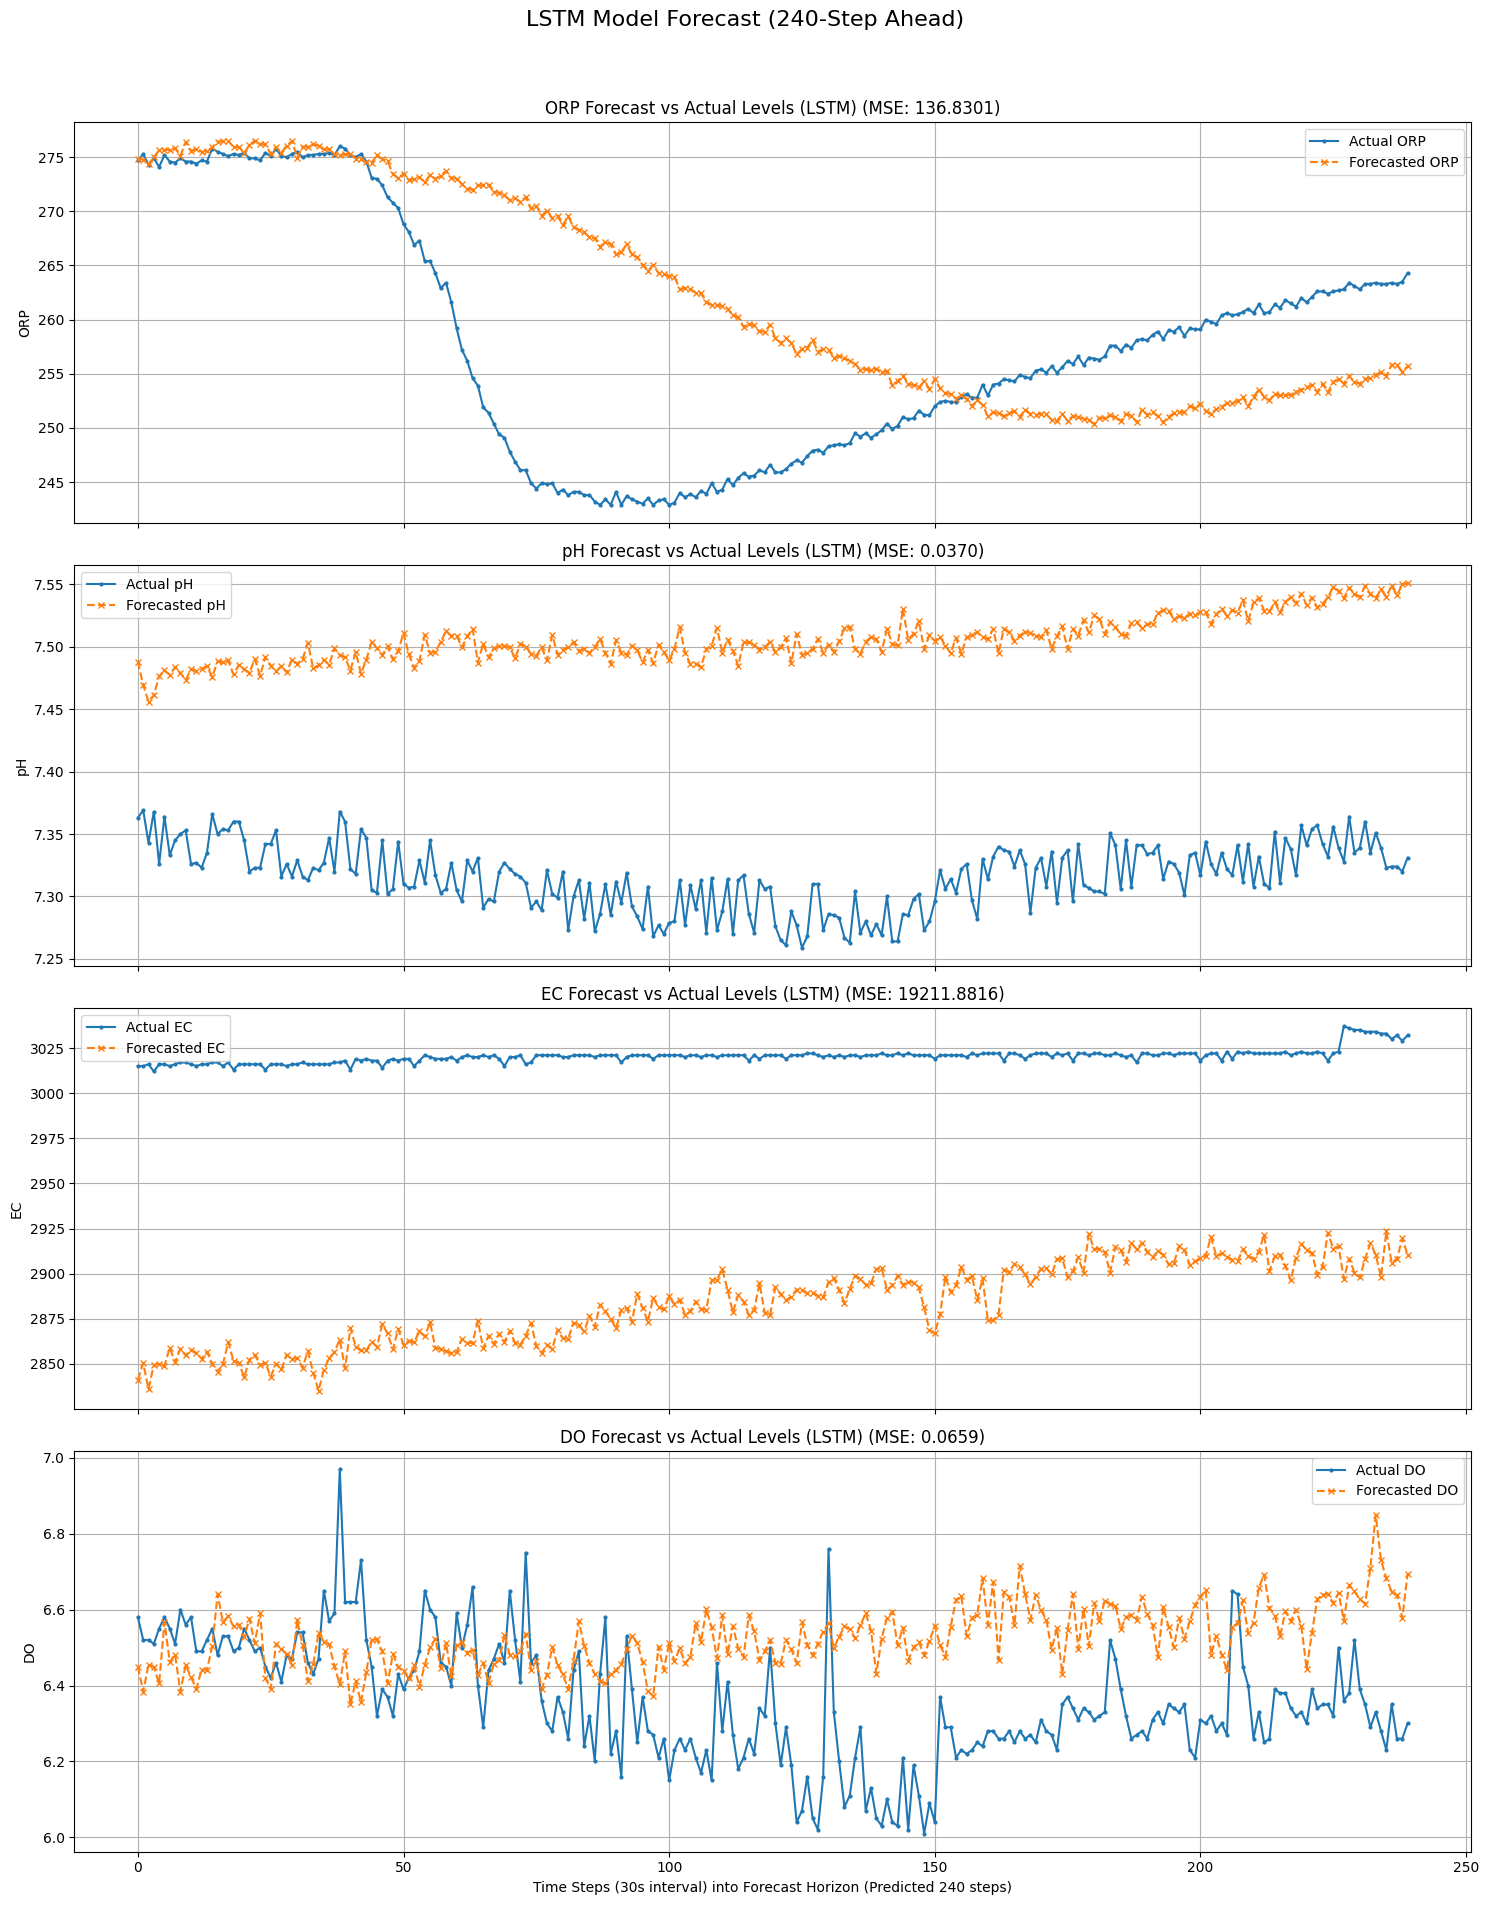


--- Script Finished ---


In [ ]:
# lstm_model.py (LSTM for 4hr history -> 30min forecast - Stabilized)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input
# Import Adam optimizer to customize it
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sys
import time
import os # For managing checkpoints

print("--- LSTM Model Script ---")
print(f"TensorFlow Version: {tf.__version__}")

# --- 1. Define Parameters ---
print("\n--- Defining Parameters ---")
n_steps_in = 240    # 4 hours * 60 min/hr * 2 steps/min = 480 steps history
n_steps_out = 240    # 30 minutes * 2 steps/min = 60 steps forecast horizon

input_cols = ['feed_effect', 'bicarbonate_effect', 'salt_effect', 'flowrate_effect','Temp']
output_cols = ['ORP','pH', 'EC', 'DO']
all_cols = input_cols + output_cols # All columns used in input sequences

n_input_features = len(input_cols)
n_output_features = len(output_cols)
n_total_features = len(all_cols) # Features in the input sequence to LSTM

df = merged_df

# --- 3. Scale Data ---
print("\n--- Scaling Data ---")
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(df) * 0.8)
df_train = df[train_size:]; df_test = df[:train_size]
print(f"Fitting scaler on training data (rows: {len(df_train)})...")
scaler.fit(df_train)
print("Scaling entire dataset...")
scaled_data = scaler.transform(df)

# --- 4. Create Sequences Function ---
print("\n--- Creating Sequences ---")
def create_sequences(data, n_steps_in, n_steps_out, target_indices):
    X, y = [], []
    print(f"Creating sequences with input length {n_steps_in}, output length {n_steps_out}...")
    for i in range(len(data)):
        end_ix = i + n_steps_in; out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data): break
        seq_x = data[i:end_ix, :]; seq_y = data[end_ix:out_end_ix, target_indices]
        X.append(seq_x); y.append(seq_y)
    print(f"Generated {len(X)} sequences.")
    return np.array(X), np.array(y)

target_indices = [df.columns.get_loc(col) for col in output_cols]
print(f"Target column indices: {target_indices}")
X_seq, y_seq = create_sequences(scaled_data, n_steps_in, n_steps_out, target_indices)



# --- 5. Split Sequence Data ---
print("\n--- Splitting Sequence Data ---")
n_train_sequences = 0
for i in range(len(scaled_data)):
     if i + n_steps_in < train_size: n_train_sequences += 1
     else: break
n_train_sequences = min(n_train_sequences, len(X_seq))
if n_train_sequences == 0: print("Error: Not enough training data."); sys.exit(1)
X_train_seq, X_test_seq = X_seq[:n_train_sequences], X_seq[n_train_sequences:]
y_train_seq, y_test_seq = y_seq[:n_train_sequences], y_seq[n_train_sequences:]
print(f"Training sequences: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"Testing sequences: X={X_test_seq.shape}, y={y_test_seq.shape}")
if len(X_test_seq) == 0: print("Warning: No test sequences generated.")

# *** Add check for NaN/Inf in sequence data before training ***
print("Checking for NaN/Inf in training sequences...")
if np.any(np.isnan(X_train_seq)) or np.any(np.isinf(X_train_seq)):
    print("Error: NaN or Inf found in X_train_seq after sequencing.")
    sys.exit(1)
if np.any(np.isnan(y_train_seq)) or np.any(np.isinf(y_train_seq)):
    print("Error: NaN or Inf found in y_train_seq after sequencing.")
    sys.exit(1)
print("No NaN/Inf found in training sequences.")

# --- 6. Build LSTM Model ---
print("\n--- Building LSTM Model ---")
model = Sequential()
model.add(Input(shape=(n_steps_in, n_total_features)))
# *** Change activation to tanh ***
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dense(n_steps_out * n_output_features))
model.add(Reshape((n_steps_out, n_output_features)))

# *** Configure optimizer with lower learning rate and gradient clipping ***
optimizer = Adam(learning_rate=0.001, clipnorm=1.0) # Lower LR and clipnorm

# Compile model
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# --- 7. Train LSTM Model ---
print("\n--- Training LSTM Model ---")
checkpoint_path = "lstm_model_checkpoint.keras"
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
validation_split = 0.1
epochs = 20
batch_size = 64

print(f"Starting training for up to {epochs} epochs (batch size: {batch_size})...")
t_start = time.time()
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Model training took {time.time() - t_start:.2f} seconds.")

if os.path.exists(checkpoint_path):
     print(f"Loading best weights from {checkpoint_path}")
     model.load_weights(checkpoint_path)
else: print("Warning: Checkpoint file not found.")

# --- 8. Make Predictions ---
print("\n--- Making Predictions ---")
if len(X_test_seq) > 0:
    print("Predicting on the first test sequence...")
    x_input_test = X_test_seq[0:1]
    y_pred_scaled = model.predict(x_input_test)
    y_actual_scaled = y_test_seq[0]

    # --- 9. Inverse Transform Predictions ---
    print("Inverse transforming predictions...")
    dummy_pred = np.zeros((n_steps_out, n_total_features))
    dummy_pred[:, target_indices] = y_pred_scaled.reshape(n_steps_out, n_output_features)
    y_pred_unscaled = scaler.inverse_transform(dummy_pred)[:, target_indices]

    dummy_actual = np.zeros((n_steps_out, n_total_features))
    dummy_actual[:, target_indices] = y_actual_scaled
    y_actual_unscaled = scaler.inverse_transform(dummy_actual)[:, target_indices]

    # --- 10. Evaluate and Plot ---
    print("\n--- Evaluating Forecast ---")
    mse = mean_squared_error(y_actual_unscaled, y_pred_unscaled, multioutput='raw_values')
    print(f"Forecast Evaluation (MSE for {n_steps_out} steps on first test sequence):")
    for i, col in enumerate(output_cols): print(f"  {col}: {mse[i]:.4f}")

    print("\n--- Plotting Results ---")
    fig, axes = plt.subplots(n_output_features, 1, figsize=(15, 5 * n_output_features), sharex=True)
    if n_output_features == 1: axes = [axes]
    time_steps = np.arange(n_steps_out)
    for i, col in enumerate(output_cols):
        axes[i].plot(time_steps, y_actual_unscaled[:, i], label=f'Actual {col}', marker='.', linestyle='-', markersize=4)
        axes[i].plot(time_steps, y_pred_unscaled[:, i], label=f'Forecasted {col}', linestyle='--', marker='x', markersize=4)
        axes[i].set_ylabel(col); axes[i].legend(); axes[i].grid(True)
        mse_val = mse[i] if i < len(mse) and not np.isnan(mse[i]) else 'N/A'
        title_mse = f' (MSE: {mse_val:.4f})' if isinstance(mse_val, float) else f' (MSE: {mse_val})'
        axes[i].set_title(f'{col} Forecast vs Actual Levels (LSTM)' + title_mse)
    axes[-1].set_xlabel(f'Time Steps (30s interval) into Forecast Horizon (Predicted {n_steps_out} steps)')
    fig.suptitle(f'LSTM Model Forecast ({n_steps_out}-Step Ahead)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plot_filename = "lstm_forecast_plot.png"
    try: fig.savefig(plot_filename); print(f"Forecast plot saved to {plot_filename}")
    except Exception as e: print(f"Error saving plot: {e}")
    plt.show()
else: print("Skipping prediction and plotting as no test sequences were generated.")

print("\n--- Script Finished ---")


Creating sequences with input length 240, output length 240...
Generated 2024 sequences.
Validation: X=(2024, 240, 9), y=(2024, 240, 4)
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE per output: {'ORP': 1606.8094898049148, 'pH': 0.06507687495852506, 'EC': 160021.31491622145, 'DO': 0.28671137276786995}


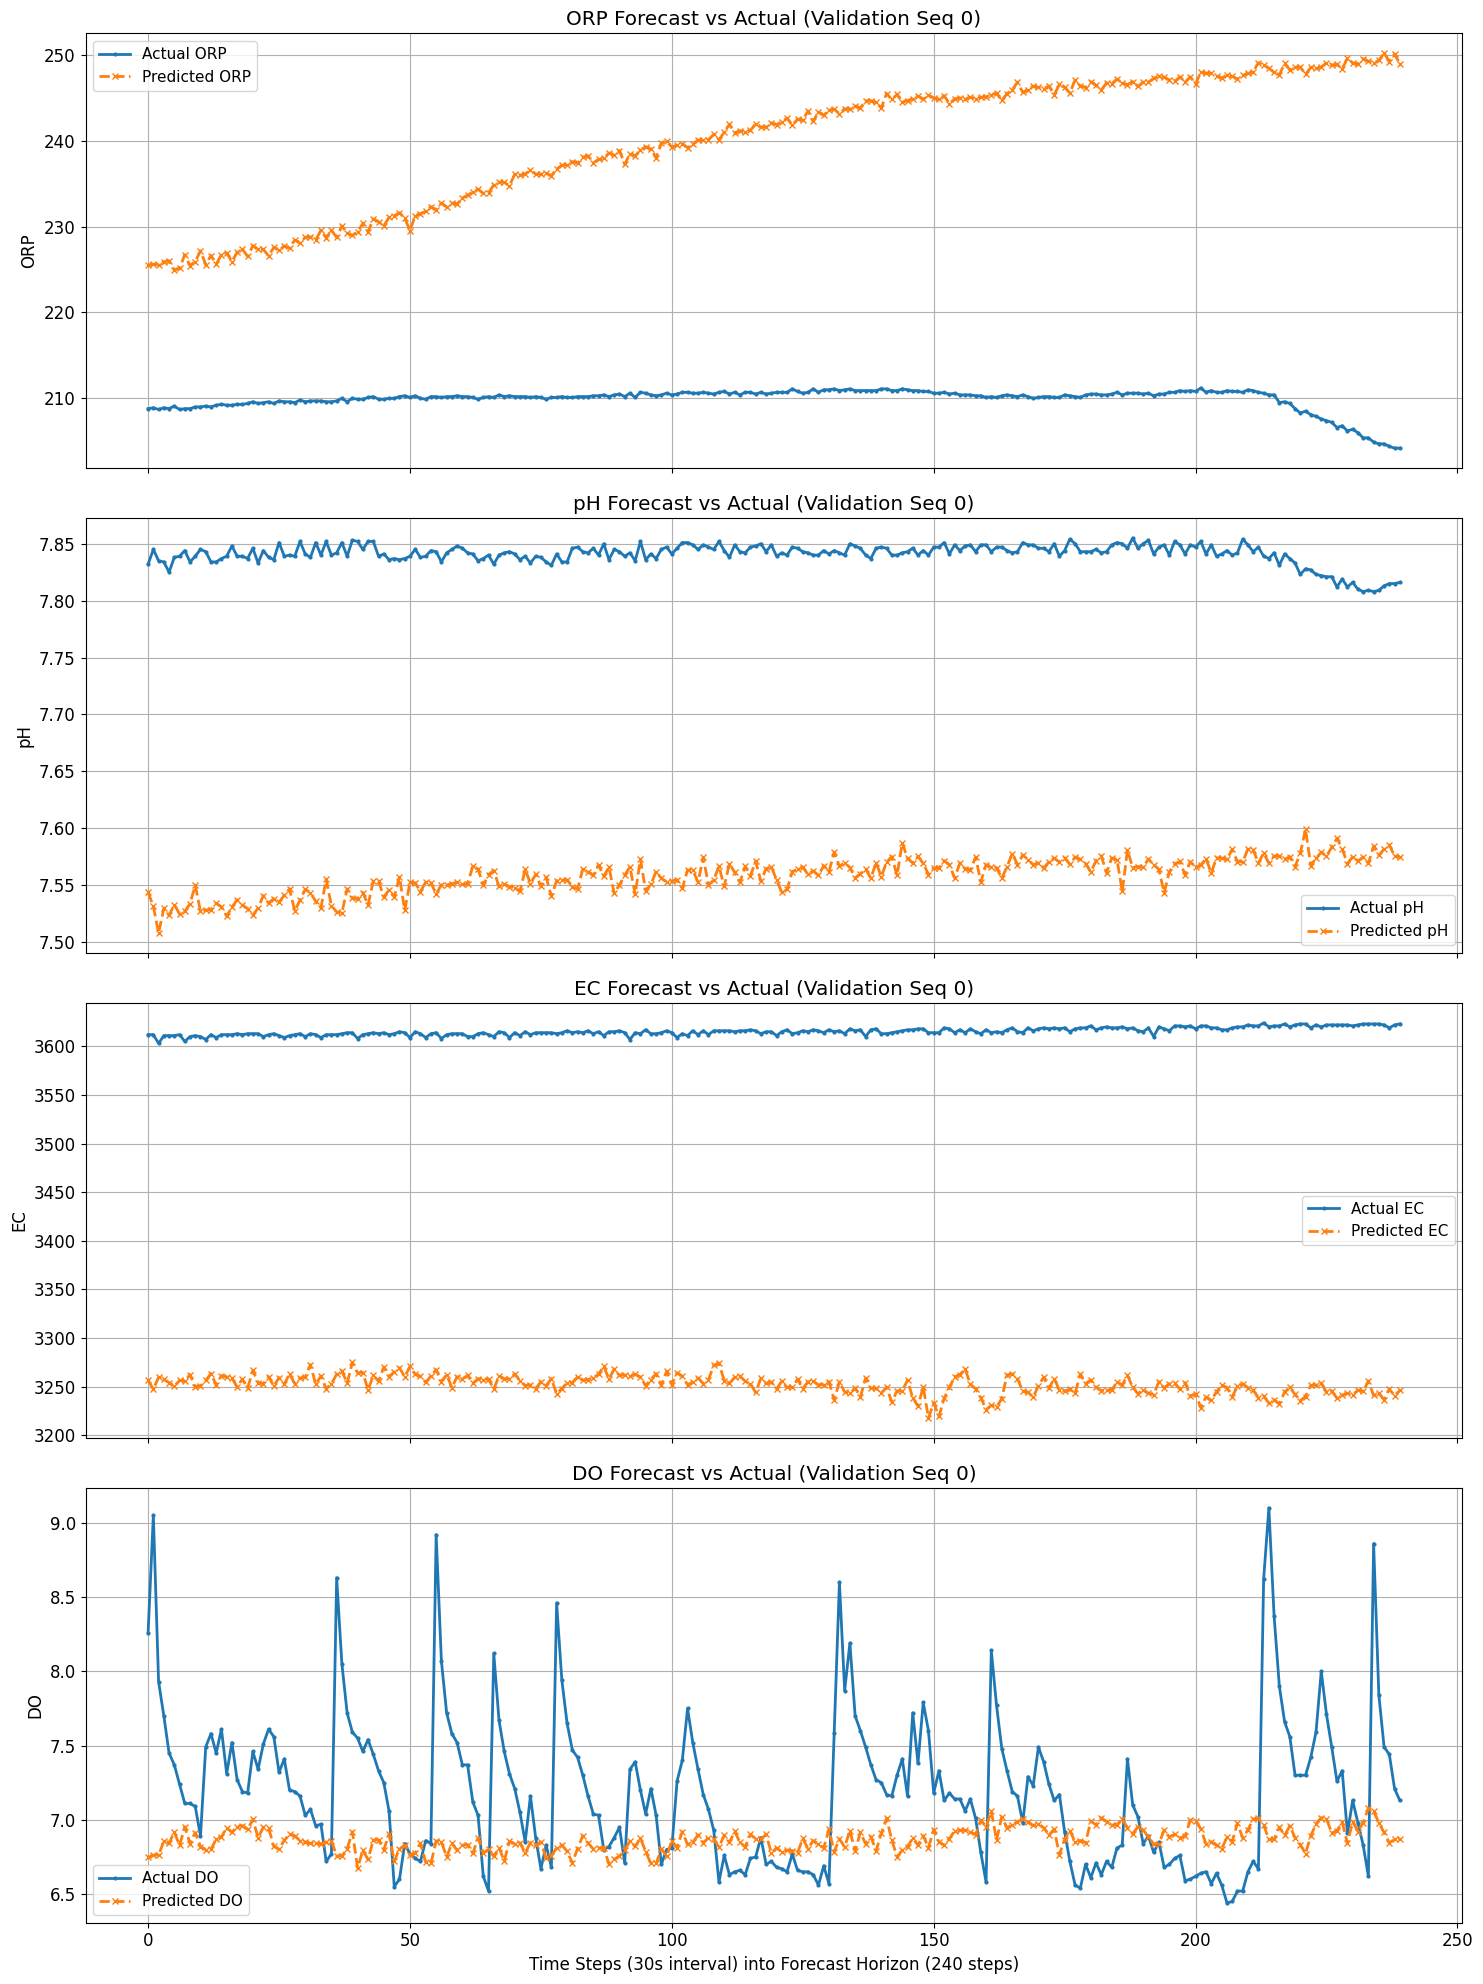

ORP RMSE: 40.0850
pH RMSE: 0.2551
EC RMSE: 400.0266
DO RMSE: 0.5355
LSTM Total RMSE: 201.0152


In [ ]:
# reorder df_val to match scaler.feature_names_in_
df_val = df_validation[scaler.feature_names_in_]

# sanity check
assert list(df_val.columns) == list(scaler.feature_names_in_), \
       "Column order still doesn't match!"

# now transform
scaled_val = scaler.transform(df_val)


# 3. Sequence
X_val_seq, y_val_seq = create_sequences(
    scaled_val,
    n_steps_in,
    n_steps_out,
    target_indices
)
print(f"Validation: X={X_val_seq.shape}, y={y_val_seq.shape}")

# 4. Predict & inverse-transform
if len(X_val_seq) > 0:
    y_val_pred_scaled = model.predict(X_val_seq)
    # Prepare dummy arrays for inverse-scaling
    n_val = len(X_val_seq)
    dummy_pred = np.zeros((n_val * n_steps_out, n_total_features))
    dummy_actual = np.zeros_like(dummy_pred)
    # Flatten and fill only the target columns
    dummy_pred[:, target_indices] = y_val_pred_scaled.reshape(-1, n_output_features)
    dummy_actual[:, target_indices] = y_val_seq.reshape(-1, n_output_features)
    # Inverse transform
    inv_pred = scaler.inverse_transform(dummy_pred)[:, target_indices]
    inv_actual = scaler.inverse_transform(dummy_actual)[:, target_indices]
    # Reshape back
    y_val_pred = inv_pred.reshape(n_val, n_steps_out, n_output_features)
    y_val_true = inv_actual.reshape(n_val, n_steps_out, n_output_features)
    # Now you can evaluate or plot exactly as before:
    mse_val = mean_squared_error(
        y_val_true.reshape(-1, n_output_features),
        y_val_pred.reshape(-1, n_output_features),
        multioutput='raw_values'
    )
    print("Validation MSE per output:", dict(zip(output_cols, mse_val)))
else:
    print("Warning: No validation sequences could be generated. Increase df_validation length?")


    import matplotlib.pyplot as plt
import numpy as np

# assuming you’ve already got:
# y_val_true: shape (n_val, n_steps_out, n_output_features)
# y_val_pred: same shape as above
# output_cols, n_steps_out, n_output_features

# For illustration we’ll plot the first validation sequence (index 0).
seq_idx = 0
time_steps = np.arange(n_steps_out)

fig, axes = plt.subplots(
    n_output_features, 1,
    figsize=(15, 5 * n_output_features),
    sharex=True
)
if n_output_features == 1:
    axes = [axes]

for i, col in enumerate(output_cols):
    axes[i].plot(
        time_steps,
        y_val_true[seq_idx, :, i],
        label=f'Actual {col}',
        marker='.', linestyle='-', markersize=4
    )
    axes[i].plot(
        time_steps,
        y_val_pred[seq_idx, :, i],
        label=f'Predicted {col}',
        linestyle='--', marker='x', markersize=4
    )
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_title(f'{col} Forecast vs Actual (Validation Seq {seq_idx})')

axes[-1].set_xlabel(
    f'Time Steps (30s interval) into Forecast Horizon ({n_steps_out} steps)'
)
plt.tight_layout()
plt.show()
# assuming you already did:
#   mse_val = mean_squared_error(..., multioutput='raw_values')

import numpy as np

# compute RMSE
rmse_val = np.sqrt(mse_val)

# print per‐sensor RMSE
for sensor, rmse in zip(output_cols, rmse_val):
    print(f"{sensor} RMSE: {rmse:.4f}")

from sklearn.metrics import mean_squared_error
import numpy as np

# flatten across all sequences & timesteps
y_true_flat = y_val_true.reshape(-1, n_output_features)
y_pred_flat = y_val_pred .reshape(-1, n_output_features)

# total RMSE (all outputs together)
rmse_lstm = np.sqrt(
    mean_squared_error(y_true_flat, y_pred_flat)
)
print(f"LSTM Total RMSE: {rmse_lstm:.4f}")


In [ ]:
import os, warnings
os.environ["OMP_NUM_THREADS"] = "8"
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# ── helper: build lagged regressor matrix ─────────────────────────────
def build_lagged(Xu, Yu, max_lag):
    n, nu = Xu.shape; ny = Yu.shape[1]
    rows  = n - max_lag
    Phi   = np.empty((rows, (nu + ny) * max_lag))
    for k in range(1, max_lag + 1):
        Phi[:, (k-1)*nu : k*nu]                 = Xu[max_lag-k : n-k]
        Phi[:, max_lag*nu + (k-1)*ny : max_lag*nu + k*ny] = Yu[max_lag-k : n-k]
    return Phi, Yu[max_lag:]


x_cols = ["feed_effect", "bicarbonate_effect",
          "salt_effect", "flowrate_effect"]
y_cols = ["ORP","pH","EC","DO"]

X_full, Y_full = merged_df[x_cols].values, merged_df[y_cols].values
X_test, Y_test = df_validation[x_cols].values, df_validation[y_cols].values


# # sx, sy = StandardScaler(), StandardScaler()
# # X_tr_s, Y_tr_s = sx.fit_transform(X_tr), sy.fit_transform(Y_tr)
# # X_te_s, Y_te_s = sx.transform(X_te),     sy.transform(Y_te)

sx, sy = StandardScaler(), StandardScaler()
X_train, Y_train = sx.fit_transform(X_full), sy.fit_transform(Y_full)
X_val, Y_val = sx.transform(X_test), sy.transform(Y_test)
print(f"Train rows: {len(X_train):,}   Test rows: {len(Y_val):,}")

# ── 3 · build lagged Φ and Y ------------------------------------------
MAX_LAG  = 240                # 2 h history 240
FORECAST = 240                # 1 h forecast 120
assert len(X_val) > MAX_LAG + FORECAST, "Test set must exceed lag + horizon"

Φ_tr, Ytar_tr = build_lagged(X_train, Y_train, MAX_LAG)
Φ_te, Ytar_te = build_lagged(X_val, Y_val, MAX_LAG)

print("Φ_tr:", Φ_tr.shape) #" Φ_te:", Φ_te.shape)


Train rows: 69,919   Test rows: 2,503
Φ_tr: (69679, 1920)


Fitted Ridge; coeffs shape: (4, 1920)


Forecast: 100%|██████████| 240/240 [00:00<00:00, 4390.22it/s]


Test‑set RMSE over 1‑hour horizon [ORP, pH, EC, DO] : 14.082544770970067
ORP RMSE: 8.389
pH RMSE: 0.009
EC RMSE: 26.881
DO RMSE: 0.545


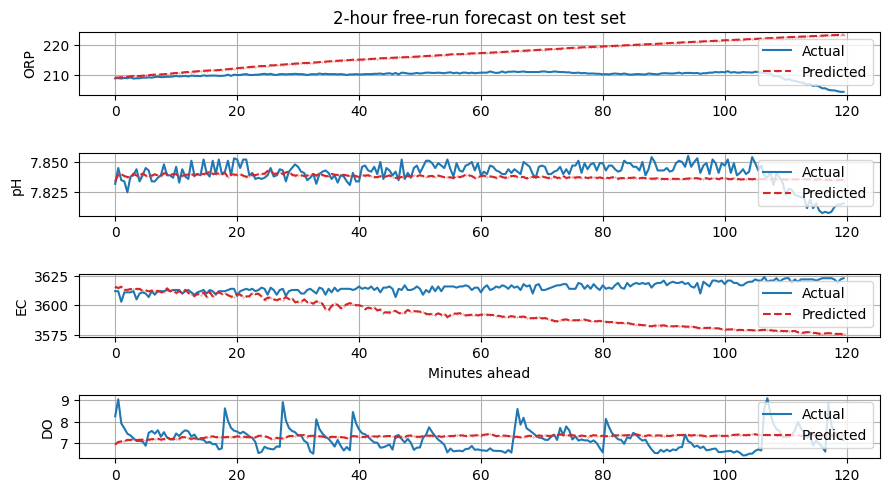

In [ ]:
"""
narx_train_test_sklearn.py
--------------------------
• chronological 80 % / 20 % split
• history: 2 h  (240 lags)
• horizon: 1 h  (120‑step free‑run forecast)
• model  : multi‑output Ridge
"""
import os, warnings
os.environ["OMP_NUM_THREADS"] = "8"
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# # ── helper: build lagged regressor matrix ─────────────────────────────
# def build_lagged(Xu, Yu, max_lag):
#     n, nu = Xu.shape; ny = Yu.shape[1]
#     rows  = n - max_lag
#     Phi   = np.empty((rows, (nu + ny) * max_lag))
#     for k in range(1, max_lag + 1):
#         Phi[:, (k-1)*nu : k*nu]                 = Xu[max_lag-k : n-k]
#         Phi[:, max_lag*nu + (k-1)*ny : max_lag*nu + k*ny] = Yu[max_lag-k : n-k]
#     return Phi, Yu[max_lag:]


# x_cols = ["feed_effect", "bicarbonate_effect",
#           "salt_effect", "flowrate_effect"]
# y_cols = ["ORP","pH", "EC", "DO","Temp"]

# X_full, Y_full = merged_df[x_cols].values, merged_df[y_cols].values
# print(f"Total rows: {len(df):,}")

# # # ── 2 · chronological 80/20 split & scaling ---------------------------
# # X_tr, X_te, Y_tr, Y_te = train_test_split(
# #     X_full, Y_full, test_size=0.20, shuffle=False)

# # sx, sy = StandardScaler(), StandardScaler()
# # X_tr_s, Y_tr_s = sx.fit_transform(X_tr), sy.fit_transform(Y_tr)
# # X_te_s, Y_te_s = sx.transform(X_te),     sy.transform(Y_te)

# sx, sy = StandardScaler(), StandardScaler()
# X_train, Y_train = sx.fit_transform(X_full), sx.fit_transform(Y_full)
# print(f"Train rows: {len(X_train):,}   Test rows: {len(Y_train):,}")

# #(f"Train rows: {len(X_tr_s):,}   Test rows: {len(X_te_s):,}")

# # ── 3 · build lagged Φ and Y ------------------------------------------
# MAX_LAG  = 480                # 2 h history 240
# FORECAST = 240                # 1 h forecast 120
# #assert len(X_te_s) > MAX_LAG + FORECAST, "Test set must exceed lag + horizon"

# Φ_tr, Ytar_tr = build_lagged(X_train, Y_train, MAX_LAG)



# #Φ_tr, Ytar_tr = build_lagged(X_tr_s, Y_tr_s, MAX_LAG)
# #Φ_te, Ytar_te = build_lagged(X_te_s, Y_te_s, MAX_LAG)

# print("Φ_tr:", Φ_tr.shape) #" Φ_te:", Φ_te.shape)

# ── 4 · fit Ridge ------------------------------------------------------
ridge = Ridge(alpha=1e-4, fit_intercept=False)
ridge.fit(Φ_tr, Ytar_tr)
print("Fitted Ridge; coeffs shape:", ridge.coef_.shape)

# ── 5 · free‑run forecast inside the test block -----------------------
# warm‑up history = first MAX_LAG rows of the Φ_te segment
Xu_hist = X_val[:MAX_LAG].copy()
Yu_hist = Y_val[:MAX_LAG].copy()

pred_scaled = []
for _ in tqdm(range(FORECAST), desc="Forecast"):
    phi_t = np.hstack([Xu_hist[::-1].reshape(-1),
                       Yu_hist[::-1].reshape(-1)]).reshape(1, -1)
    y_hat = ridge.predict(phi_t)
    pred_scaled.append(y_hat[0])
    Xu_hist = np.vstack([Xu_hist, X_val[MAX_LAG]])[-MAX_LAG:]
    Yu_hist = np.vstack([Yu_hist, y_hat])[-MAX_LAG:]

Ridge_pred   = sy.inverse_transform(np.array(pred_scaled))
actual   = sy.inverse_transform(Y_val[MAX_LAG : MAX_LAG + FORECAST])

rmse = np.sqrt(mean_squared_error(actual, Ridge_pred))
print(f"\nTest‑set RMSE over 1‑hour horizon [ORP, pH, EC, DO] : {rmse}")

# Compute RMSE for each sensor separately
rmse_per_sensor = np.sqrt(
    mean_squared_error(actual, Ridge_pred, multioutput='raw_values')
)

sensor_names = ["ORP", "pH", "EC", "DO"]
for name, rmse_val in zip(sensor_names, rmse_per_sensor):
    print(f"{name} RMSE: {rmse_val:.3f}")


# ── 6 · plot comparison -----------------------------------------------
minutes = np.arange(FORECAST) * 0.5
labels  = ["ORP", "pH", "EC", "DO"]

plt.figure(figsize=(9,6))
for j, var in enumerate(y_cols):
    ax = plt.subplot(5,1,j+1)
    ax.plot(minutes, actual[:, j], label="Actual",  color="tab:blue")
    ax.plot(minutes, Ridge_pred[:, j], '--', marker='.', markersize=0.5,
            label="Predicted", color="tab:red")
    ax.set_ylabel(var); ax.grid(True)
    if j == 0:
        ax.set_title("2‑hour free‑run forecast on test set")
    if j == 2:
        ax.set_xlabel("Minutes ahead")
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

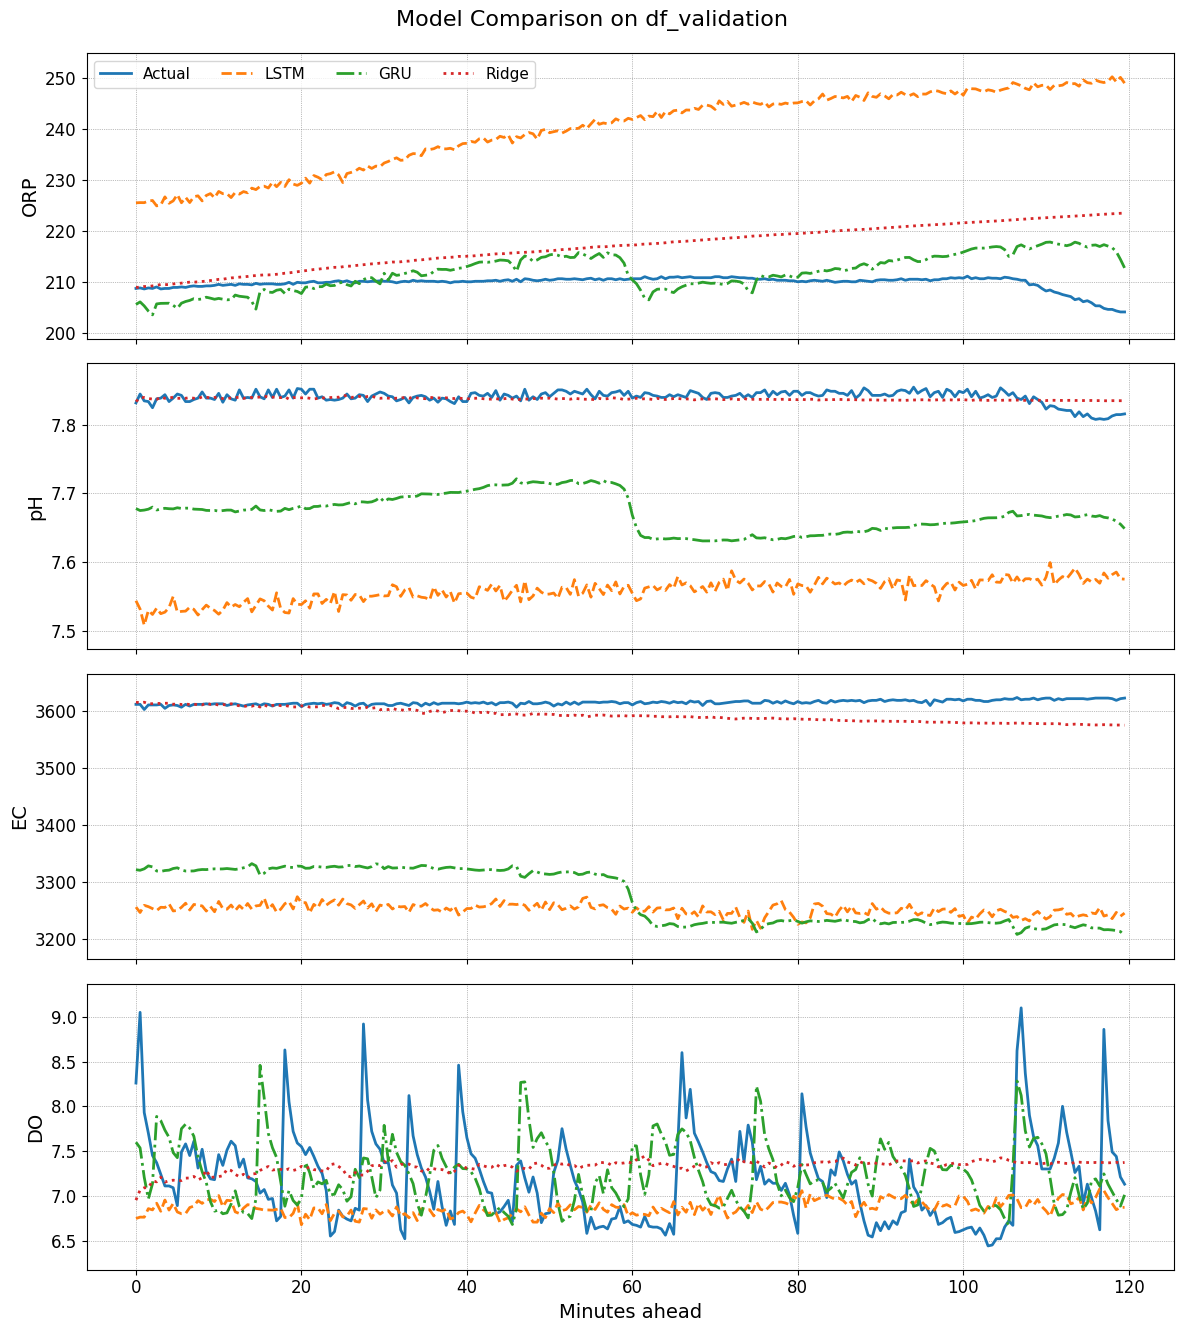

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Sensor names and data (make sure these exist in your namespace)
sensor_names = ["ORP", "pH", "EC", "DO"]
lstm_pred_seq   = y_val_pred[0]      # shape (T,4)
lstm_actual_seq = y_val_true[0]      # shape (T,4)
gru_pred        = y_pred_val         # shape (T,4)
ridge_pred      = Ridge_pred         # shape (T,4)

# 2. Align horizons
horizons = [arr.shape[0] for arr in (lstm_pred_seq, lstm_actual_seq, gru_pred, ridge_pred)]
h = min(horizons)
t = np.arange(h) * 0.5  # minutes

# 3. Plot
plt.rcParams.update({
    "figure.figsize": (12, 14),
    "font.size": 12,
    "lines.linewidth": 2,
    "legend.fontsize": 11
})

fig, axes = plt.subplots(4, 1, sharex=True)

for i, sensor in enumerate(sensor_names):
    ax = axes[i]
    ax.plot(t, lstm_actual_seq[:h, i],  '-',  label="Actual")
    ax.plot(t, lstm_pred_seq[:h, i],    '--', label="LSTM")
    ax.plot(t, gru_pred[:h, i],         '-.', label="GRU")
    ax.plot(t, ridge_pred[:h, i],       ':',  label="Ridge")

    ax.set_ylabel(sensor, fontsize=14)
    ax.grid(color='gray', linestyle=':', linewidth=0.5)
    # Put legend only on the first subplot
    if i == 0:
        ax.legend(loc='upper left', ncol=4, frameon=True)
    # Add a little margin between subplots
    ax.margins(y=0.1)

# common labels & title
axes[-1].set_xlabel("Minutes ahead", fontsize=14)
fig.suptitle("Model Comparison on df_validation", fontsize=16, y=0.95)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [ ]:
import os, warnings
os.environ["OMP_NUM_THREADS"] = "8"
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

# ── helper: build GRU input tensors ───────────────────────────────────
def build_sequences(Xu, Yu, seq_len):
    """Return Xseq (N, T, 7) and Y (N, 3) aligned."""
    n = len(Xu) - seq_len
    feats = np.concatenate([Xu, Yu], axis=1)      # 7 features
    Xseq  = np.empty((n, seq_len, feats.shape[1]))
    for t in range(seq_len):
        Xseq[:, t, :] = feats[t : t+n]
        feats = np.roll(feats, -1, axis=0)        # shift once
    Ytar = Yu[seq_len:]
    return Xseq.astype("float32"), Ytar.astype("float32")


# x_cols = ["feed_effect","bicarbonate_effect","salt_effect","flowrate_effect"]
# y_cols = ["ORP","pH","EC","DO","Temp"]
# X_all, Y_all = merged_df[x_cols].values, merged_df[y_cols].values
# print(f"Total rows : {len(merged_df):,}")

# # ── 2 · split & scale --------------------------------------------------
# X_tr, X_te, Y_tr, Y_te = train_test_split(
#     X_all, Y_all, test_size=0.20, shuffle=False)
# sx, sy = StandardScaler(), StandardScaler()
# X_tr_s, Y_tr_s = sx.fit_transform(X_tr), sy.fit_transform(Y_tr)
# X_te_s, Y_te_s = sx.transform(X_te),     sy.transform(Y_te)

SEQ   = 480            # 2 h 240
HORIZ = 240            # 1 h forecast 120
assert len(X_val) > SEQ + HORIZ, "Test set too small for chosen horizon."

Xseq_tr, Y_tr_t = build_sequences(X_train, Y_train, SEQ)
Xseq_te, Y_te_t = build_sequences(X_val, Y_val, SEQ)
print("Train tensors :", Xseq_tr.shape, Y_tr_t.shape)


Train tensors : (69439, 480, 9) (69439, 5)


Train rows: 69,919   Test rows: 2,503
Train tensors : (69439, 480, 9) (69439, 5)
Epoch   1  val_loss=0.035779
Epoch   2  val_loss=0.029363
Epoch   3  val_loss=0.026748
Epoch   4  val_loss=0.025633
Epoch   5  val_loss=0.024927
Epoch   6  val_loss=0.024918
Epoch   7  val_loss=0.024753
Epoch   8  val_loss=0.024016
Epoch   9  val_loss=0.023713
Epoch  10  val_loss=0.023960
Epoch  11  val_loss=0.024224
Epoch  12  val_loss=0.023462
Epoch  13  val_loss=0.023551
Epoch  14  val_loss=0.023410
Epoch  15  val_loss=0.023595
Epoch  16  val_loss=0.023461
Epoch  17  val_loss=0.023430
Epoch  18  val_loss=0.023554
Epoch  19  val_loss=0.023822
Early stop at epoch 19
Overall RMSE: 223.20153559606928
ORP RMSE: 17.507
pH RMSE: 0.316
EC RMSE: 498.786
DO RMSE: 0.574
Temp RMSE: 0.251


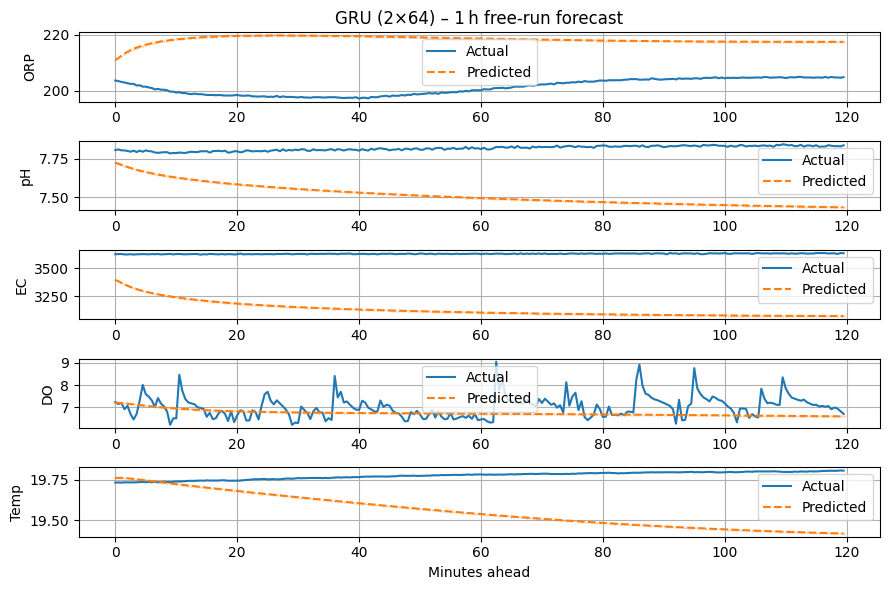

In [ ]:
"""
narx_gru_gpu_fixed.py
---------------
• chronological 80 % / 20 % split
• 2 h history  (480 steps @ 30 s)
• GRU( input=9, hidden=64, layers=2 ) → Linear(5)
• 4 h forecast free‑run: uses true exogenous inputs
"""

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) prepare data
x_cols = ["feed_effect","bicarbonate_effect","salt_effect","flowrate_effect","Temp"]
y_cols = ["ORP","pH","EC","DO"]

X_full, Y_full = merged_df[x_cols].values, merged_df[y_cols].values
X_test,  Y_test  = df_validation[x_cols].values, df_validation[y_cols].values

sx, sy = StandardScaler(), StandardScaler()
X_train, Y_train = sx.fit_transform(X_full), sy.fit_transform(Y_full)
X_val,   Y_val   = sx.transform(X_test),    sy.transform(Y_test)
print(f"Train rows: {len(X_train):,}   Test rows: {len(Y_val):,}")

# 2) build lagged sequences
SEQ   = 480   # 2 h history
HORIZ = 240   # 1 h forecast (240 steps)
assert len(X_val) > SEQ + HORIZ

# build autoregressive input: concat exog + sensor history
def build_sequences(X, Y, seq_len):
    n = len(X) - seq_len
    feats = np.concatenate([X, Y], axis=1)
    Xseq = np.stack([feats[i:i+seq_len] for i in range(n)], axis=0)
    Ytar = Y[seq_len:]
    return Xseq.astype('float32'), Ytar.astype('float32')

Xseq_tr, Y_tr_t = build_sequences(X_train, Y_train, SEQ)
print("Train tensors :", Xseq_tr.shape, Y_tr_t.shape)

# split train/val
ds = TensorDataset(torch.from_numpy(Xseq_tr), torch.from_numpy(Y_tr_t))
val_len = int(0.1*len(ds))
train_ds, val_ds = random_split(ds, [len(ds)-val_len, val_len], generator=torch.Generator().manual_seed(0))
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=512)

# 3) define GRU
class GRUNet(nn.Module):
    def __init__(self, inp_dim, hidden=64, layers=2, out_dim=5):
        super().__init__()
        self.gru = nn.GRU(inp_dim, hidden, layers, batch_first=True, dropout=0.2)
        self.fc  = nn.Linear(hidden, out_dim)
    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = GRUNet(inp_dim=Xseq_tr.shape[2]).to(device)
opt = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

# 4) training loop (increase epochs)
best_val, stall = np.inf, 0
patience = 5
for epoch in range(100):  # train up to 100 epochs
    net.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss_fn(net(xb), yb).backward()
        opt.step()
    # validation
    net.eval(); val_loss, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            l = loss_fn(net(xb), yb).item()*xb.size(0)
            val_loss += l; n += xb.size(0)
    val_loss /= n
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:3d}  val_loss={val_loss:.6f}")
    if val_loss + 1e-6 < best_val:
        best_val = val_loss; stall = 0
        best_state = net.state_dict()
    else:
        stall += 1
    if stall >= patience:
        print("Early stop at epoch", epoch+1)
        break
net.load_state_dict(best_state)

# 5) free-run forecast
hist_in  = torch.tensor(X_val,   dtype=torch.float32, device=device)[:SEQ]
hist_out = torch.tensor(Y_val,   dtype=torch.float32, device=device)[:SEQ]
preds_scaled = []
net.eval()
with torch.no_grad():
    for t in range(HORIZ):
        seq = torch.cat([hist_in, hist_out], dim=1).unsqueeze(0)
        y_hat = net(seq).squeeze(0)
        preds_scaled.append(y_hat.cpu().numpy())
        # slide window: use true exogenous at time SEQ+t
        new_exog = torch.tensor(X_val[SEQ + t], dtype=torch.float32, device=device)
        hist_in  = torch.vstack([hist_in[1:], new_exog])
        hist_out = torch.vstack([hist_out[1:], y_hat])

# 6) inverse scale & metrics
GRU_pred = sy.inverse_transform(np.vstack(preds_scaled))
actual   = sy.inverse_transform(Y_val[SEQ:SEQ+HORIZ])
rmse = np.sqrt(mean_squared_error(actual, GRU_pred))
print("Overall RMSE:", rmse)
mse_per = mean_squared_error(actual, GRU_pred, multioutput='raw_values')
rmse_per = np.sqrt(mse_per)
for n, r in zip(y_cols, rmse_per): print(f"{n} RMSE: {r:.3f}")

# 7) plot
mins = np.arange(HORIZ)*0.5
plt.figure(figsize=(9,6))
for j,var in enumerate(y_cols):
    ax = plt.subplot(len(y_cols),1,j+1)
    ax.plot(mins, actual[:,j], label="Actual")
    ax.plot(mins, GRU_pred[:,j], '--.', ms=0.5, label="Predicted")
    ax.set_ylabel(var); ax.grid(True)
    if j==0: ax.set_title("GRU (2×64) – 1 h free‑run forecast")
    if j==len(y_cols)-1: ax.set_xlabel("Minutes ahead")
    ax.legend()
plt.tight_layout(); plt.show()


In [ ]:
# lstm_model.py (LSTM for 4hr history -> 30min forecast - Stabilized)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input
# Import Adam optimizer to customize it
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sys
import time
import os # For managing checkpoints

print("--- LSTM Model Script ---")
print(f"TensorFlow Version: {tf.__version__}")

# --- 1. Define Parameters ---
print("\n--- Defining Parameters ---")
n_steps_in = 480    # 4 hours * 60 min/hr * 2 steps/min = 480 steps history
n_steps_out = 240    # 30 minutes * 2 steps/min = 60 steps forecast horizon


input_cols = ['feed_effect', 'bicarbonate_effect', 'salt_effect', 'flowrate_effect']
output_cols = ['ORP','pH', 'EC', 'DO','Temp']
all_cols = input_cols + output_cols # All columns used in input sequences

n_input_features = len(input_cols)
n_output_features = len(output_cols)
n_total_features = len(all_cols) # Features in the input sequence to LSTM


# --- 3. Scale Data ---
print("\n--- Scaling Data ---")
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(merged_df))
df_train = merged_df; df_test = df_validation
print(f"Fitting scaler on training data (rows: {len(df_train)})...")
scaler.fit(df_train)
print("Scaling entire dataset...")
scaled_data = scaler.transform(merged_df)

# --- 4. Create Sequences Function ---
print("\n--- Creating Sequences ---")
def create_sequences(data, n_steps_in, n_steps_out, target_indices):
    X, y = [], []
    print(f"Creating sequences with input length {n_steps_in}, output length {n_steps_out}...")
    for i in range(len(data)):
        end_ix = i + n_steps_in; out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data): break
        seq_x = data[i:end_ix, :]; seq_y = data[end_ix:out_end_ix, target_indices]
        X.append(seq_x); y.append(seq_y)
    print(f"Generated {len(X)} sequences.")
    return np.array(X), np.array(y)

target_indices = [merged_df.columns.get_loc(col) for col in output_cols]
print(f"Target column indices: {target_indices}")
X_seq, y_seq = create_sequences(scaled_data, n_steps_in, n_steps_out, target_indices)

# --- 5 · Build train & validation sequences — no chronological split here ---
print("\n--- Creating Train Sequences ---")
X_train_seq, y_train_seq = create_sequences(
    scaler.transform(merged_df),
    n_steps_in, n_steps_out, target_indices
)
print(f"Training sequences: X={X_train_seq.shape}, y={y_train_seq.shape}")

print("\n--- Creating Validation Sequences ---")
scaled_val = scaler.transform(df_validation)
X_val_seq, y_val_seq = create_sequences(
    scaled_val,
    n_steps_in, n_steps_out, target_indices
)
print(f"Validation sequences: X={X_val_seq.shape}, y={y_val_seq.shape}")

# --- 6. Build LSTM Model ---
print("\n--- Building LSTM Model ---")
model = Sequential()
model.add(Input(shape=(n_steps_in, n_total_features)))
# *** Change activation to tanh ***
model.add(LSTM(units=64, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out * n_output_features))
model.add(Reshape((n_steps_out, n_output_features)))


# *** Configure optimizer with lower learning rate and gradient clipping ***
optimizer = Adam(learning_rate=0.001, clipnorm=1.0) # Lower LR and clipnorm

# Compile model
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# --- 7. Train LSTM Model ---
print("\n--- Training LSTM Model ---")
checkpoint_path = "lstm_model_checkpoint.keras"
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}.h5', monitor='val_loss', save_best_only=True)
validation_split = 0.1
epochs = 200
batch_size = 64

print(f"Starting training for up to {epochs} epochs (batch size: {batch_size})...")
t_start = time.time()
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print(f"Model training took {time.time() - t_start:.2f} seconds.")

if os.path.exists(checkpoint_path):
     print(f"Loading best weights from {checkpoint_path}")
     model.load_weights(checkpoint_path)
else: print("Warning: Checkpoint file not found.")

# --- 8 · Make Predictions on Validation Set ---
print("\n--- Making Predictions on Validation Set ---")
if len(X_val_seq) > 0:
    x_input_test    = X_val_seq[0:1]          # first validation window
    y_pred_scaled   = model.predict(x_input_test)
    y_actual_scaled = y_val_seq[0]

    # --- 9 · Inverse Transform Predictions ---
    dummy_pred = np.zeros((n_steps_out, n_total_features))
    dummy_pred[:, target_indices] = y_pred_scaled.reshape(n_steps_out, n_output_features)
    y_pred_unscaled   = scaler.inverse_transform(dummy_pred)[:, target_indices]

    dummy_act = np.zeros((n_steps_out, n_total_features))
    dummy_act[:, target_indices] = y_actual_scaled
    y_actual_unscaled = scaler.inverse_transform(dummy_act)[:, target_indices]

    # --- 10 · Compute RMSE and Plot ---
    from sklearn.metrics import mean_squared_error

    # Per‐sensor RMSE
    mse_per_sensor = mean_squared_error(
        y_actual_unscaled,
        y_pred_unscaled,
        multioutput='raw_values'
    )
    rmse_per_sensor = np.sqrt(mse_per_sensor)

    # Overall RMSE
    overall_rmse = np.sqrt(
        mean_squared_error(
            y_actual_unscaled.flatten(),
            y_pred_unscaled.flatten()
        )
    )

    # Print RMSEs
    print(f"Overall RMSE (all sensors): {overall_rmse:.4f}")
    for col, rmse in zip(output_cols, rmse_per_sensor):
        print(f"{col} RMSE: {rmse:.4f}")

    # Plotting against minutes
    minutes = np.arange(n_steps_out) * 0.5  # 30 s → 0.5 min per step

    fig, axes = plt.subplots(
        n_output_features, 1,
        figsize=(15, 5 * n_output_features),
        sharex=True
    )
    if n_output_features == 1:
        axes = [axes]

    for i, col in enumerate(output_cols):
        axes[i].plot(
            minutes, y_actual_unscaled[:, i],
            label=f'Actual {col}',
            marker='.', linestyle='-',
            markersize=4
        )
        axes[i].plot(
            minutes, y_pred_unscaled[:, i],
            label=f'Forecasted {col}',
            linestyle='--', marker='x',
            markersize=4
        )
        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_title(f'{col}: RMSE = {rmse_per_sensor[i]:.3f}')

    axes[-1].set_xlabel('Minutes ahead')
    fig.suptitle(
        f'LSTM Model Forecast ({n_steps_out*0.5:.0f} min Horizon)',
        fontsize=16
    )
    plt.tight_layout(rect=[0,0.03,1,0.96])
    plt.show()

else:
    print("No validation sequences generated; check df_validation length.")

print("\n--- Script Finished ---")

--- LSTM Model Script ---
TensorFlow Version: 2.18.0

--- Defining Parameters ---

--- Scaling Data ---
Fitting scaler on training data (rows: 69919)...
Scaling entire dataset...

--- Creating Sequences ---
Target column indices: [4, 5, 6, 7, 8]
Creating sequences with input length 480, output length 240...
Generated 69200 sequences.

--- Creating Train Sequences ---
Creating sequences with input length 480, output length 240...
Generated 69200 sequences.
Training sequences: X=(69200, 480, 9), y=(69200, 240, 5)

--- Creating Validation Sequences ---
Creating sequences with input length 480, output length 240...
Generated 1784 sequences.
Validation sequences: X=(1784, 480, 9), y=(1784, 240, 5)

--- Building LSTM Model ---


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 480, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 480, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1200)           │        39,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 240, 5)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,960 (277.19 KB)

 Trainable params: 70,960 (277.19 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Starting training for up to 200 epochs (batch size: 64)...
Epoch 1/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0486

974/974 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - loss: 0.0486 - val_loss: 0.0079
Epoch 2/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 3/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0060

974/974 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 4/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 5/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - loss: 0.0039 - val_loss: 0.0076
Epoch 6/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 7/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0035 - val_loss: 0.0083
Epoch 8/200
974/974 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 0.0034 - val_loss: 0.0100
Model training took 339.75 seconds.
Loading best weights from lstm_model_checkpoint.keras


ValueError: A total of 4 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(9, 256), Received: value.shape=(4, 400). Target variable: <Variable path=sequential_25/lstm_49/lstm_cell/kernel, shape=(9, 256), dtype=float32, value=[[-0.15458615  0.10123416 -0.05303975 ... -0.1344218  -0.05637825
   0.08473326]
 [ 0.02330551  0.1087626  -0.24423593 ... -0.05057626  0.01998081
   0.0517953 ]
 [-0.15309337 -0.10535151 -0.37277415 ... -0.04818805  0.16185644
   0.08510291]
 ...
 [-0.01057028 -0.16510285  0.04722555 ...  0.14981623 -0.00533839
   0.12445115]
 [-0.20791389 -0.00245908 -0.15104362 ... -0.02479735 -0.06114515
   0.16689365]
 [ 0.06665014 -0.03557023 -0.11841141 ...  0.04242083 -0.0381708
   0.016104  ]]>

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>, <LSTMCell name=lstm_cell, built=True>, <Dense name=dense_25, built=True>, <keras.src.optimizers.adam.Adam object at 0x7a586da77710>]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Make sure you’ve collected your arrays:
#    actual:      (T, n_vars)
#    ridge_preds: (T, n_vars)
#    gru_preds:   (T, n_vars)
#    lstm_preds:  (T, n_vars)
#    minutes:     length-T array of time points (e.g. np.arange(T)*0.5)
#    labels:      e.g. ["pH","EC","DO"]

# Ridge script:
ridge_preds = Ridge_pred.copy()          # shape (T, n_vars)

# GRU script:
gru_preds   = GRU_pred.copy()

# LSTM script:
lstm_preds  = y_pred_unscaled.copy()

# 2) Put the model predictions in a dict for easy looping
predictions = {
    "Ridge-NARX": ridge_preds,
    "GRU (2×64)" : gru_preds,
    "LSTM"       : lstm_preds
}

labels = ["ORP","pH","EC","DO","Temp"]

# 3) Plot
n_vars = actual.shape[1]
fig, axes = plt.subplots(n_vars, 1, sharex=True, figsize=(8, 2.5*n_vars))

for i, var in enumerate(labels):
    ax = axes[i] if n_vars > 1 else axes
    # plot actual once
    ax.plot(minutes, actual[:,i], label="Actual", color="black", linewidth=2)
    # overlay each model
    for name, preds in predictions.items():
        ax.plot(minutes, preds[:,i], label=name, linestyle="--", marker=".", markersize=0.5)
    ax.set_ylabel(var)
    ax.grid(True)
    if i == 0:
        ax.set_title("4 h Forecast Comparison")
    if i == n_vars-1:
        ax.set_xlabel("Minutes ahead")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


NameError: name 'Ridge_pred' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Global style: run once at top of your notebook/script
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'figure.dpi': 100,
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'small',
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
})

def compare_models_plot(actual, predictions, time_axis, variables):
    """
    actual      : np.array (T, n_vars)
    predictions : dict of {model_name: np.array (T, n_vars)}
    time_axis   : np.array length T
    variables   : list of length n_vars
    """
    n_vars = len(variables)
    n_models = len(predictions)
    model_names = list(predictions.keys())

    # Set up a grid with n_vars rows and n_models+1 columns:
    fig, axes = plt.subplots(n_vars, n_models+1,
                             sharex='col', sharey='row',
                             figsize=(4*(n_models+1), 3*n_vars))

    for i, var in enumerate(variables):
        # Column 0: actual
        ax = axes[i, 0] if n_vars>1 else axes[0]
        ax.plot(time_axis, actual[:,i], label='Actual', color='tab:blue')
        ax.set_ylabel(var)
        if i == 0:
            ax.set_title("Actual")
        ax.grid(True)
        if i == n_vars-1:
            ax.set_xlabel("Minutes ahead")

        # Columns 1…: each model
        for j, name in enumerate(model_names, start=1):
            ax = axes[i, j] if n_vars>1 else axes[j]
            pred = predictions[name]
            ax.plot(time_axis, pred[:,i], label=name, color='tab:red')
            if i == 0:
                ax.set_title(name)
            ax.grid(True)
            if i == n_vars-1:
                ax.set_xlabel("Minutes ahead")

    # Add a single legend (optional)
    # handles = [plt.Line2D([], [], color='tab:blue', label='Actual')] + \
    #           [plt.Line2D([], [], color='tab:red', label=name) for name in model_names]
    # fig.legend(handles=handles, loc='upper right')

    plt.tight_layout()
    plt.show()


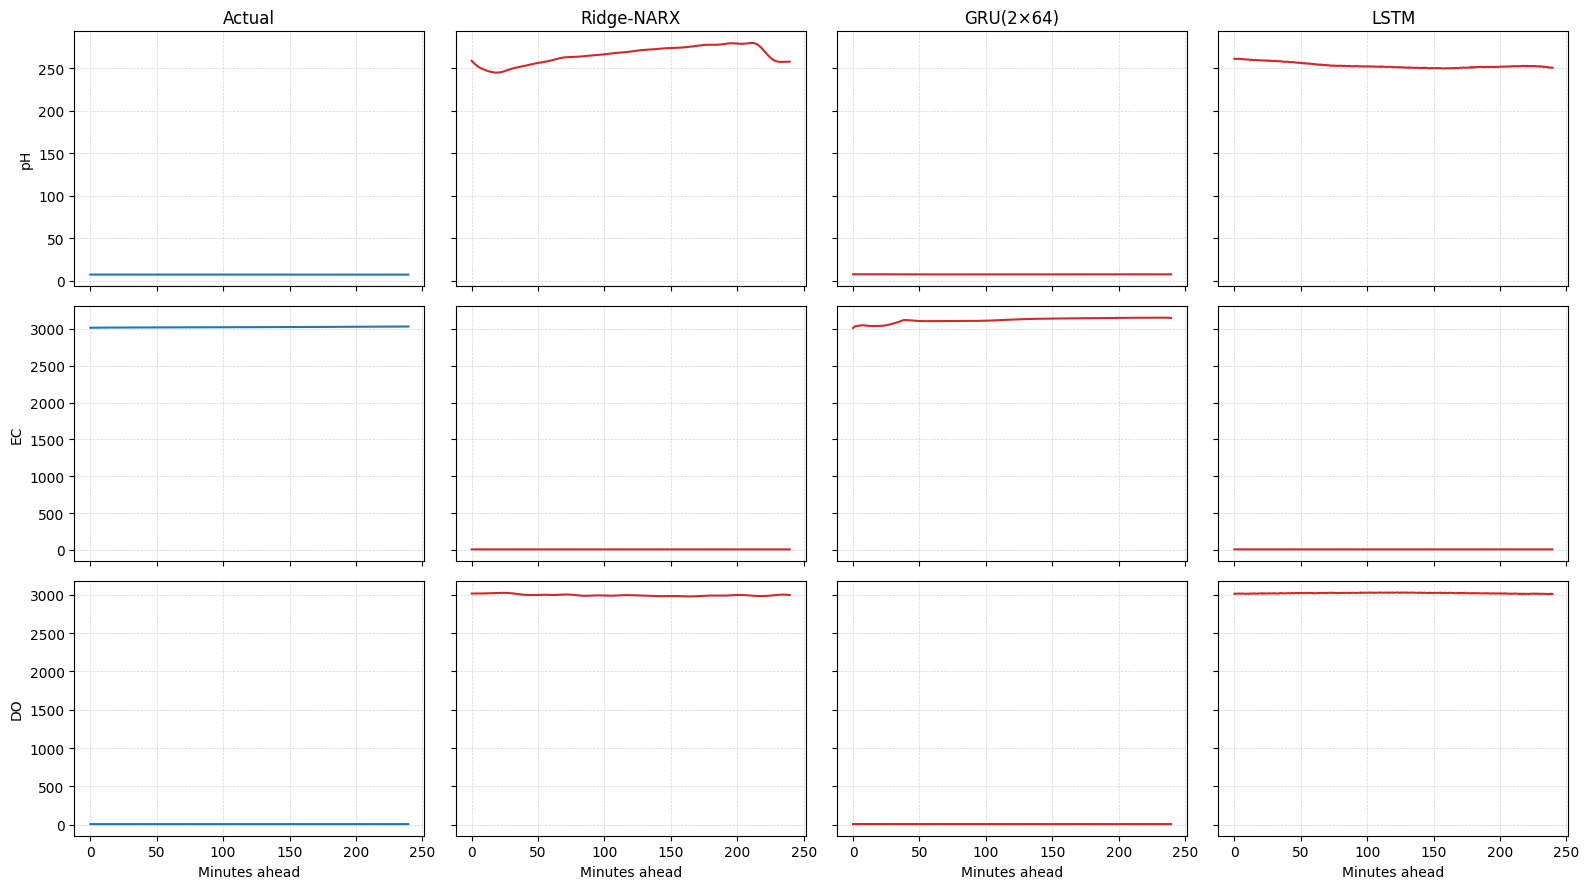

In [ ]:
# Ridge script:
ridge_preds = Ridge_pred.copy()          # shape (T, n_vars)

# GRU script:
gru_preds   = GRU_pred.copy()

# LSTM script:
lstm_preds  = y_pred_unscaled.copy()

# They should all use the same “actual” slice:
actual = actual  # from any of the scripts, same test segment

# e.g. minutes = 0.5 * np.arange(actual.shape[0])
minutes = np.arange(actual.shape[0]) * 0.5


predictions = {
  "Ridge-NARX" : ridge_preds[:, :5],   # if you only want pH, EC, DO
  "GRU(2×64)"  : gru_preds,
  "LSTM"       : lstm_preds
}
labels = ["pH","EC","DO"]   # or whatever subset you’re comparing

compare_models_plot(actual[:, :3], predictions, minutes, labels)

OLD CODE!!!

In [ ]:
# 1) figure out the 10-day cutoff
start = merged_df.index.min()
end   = start + pd.Timedelta(days=14)

# 2) slice to the first 10 days, then keep only times between 12:00 and 18:00
df_10d = merged_df.loc[start:end]\
                   .between_time('12:00', '18:00')

# 3) reset_index to make 'Timestamp' a column, then set 'Time elapsed' as the new index
df_final = (df_10d
            .reset_index()                        # brings Timestamp back as a column
            .set_index('Time elapsed', drop=True) # index on your elapsed‐time
            .drop(columns=['Timestamp'])          # ditch the old timestamp col
           )

# df_final is now exactly 10 days × 6 hours/day, indexed by Time elapsed
df_10d

# # 2) Keep only rows between 12:00 and 18:00
# #    (merged_df.index must be a DatetimeIndex here)
# df_midday = merged_df.between_time('12:00', '18:00')
# print("After filtering to 12–18h:", df_midday.shape)

# # 3) Plot the filtered data
# import matplotlib.pyplot as plt

# sensor_cols = ['ORP','pH','EC','DO (mg/L)','Temp']
# sensor_colors = {
#     'ORP': 'blue',
#     'pH': 'red',
#     'EC': 'green',
#     'DO (mg/L)': 'orange',
#     'Temp': 'black'
# }

# # create subplots for each sensor
# axarr = df_midday[sensor_cols].plot(subplots=True, figsize=(12, 10), legend=False)

# for ax, col in zip(axarr, sensor_cols):
#     line = ax.get_lines()[0]
#     line.set_color(sensor_colors[col])
#     ax.set_title(f"{col} (12:00–18:00)", color=sensor_colors[col])
#     ax.set_xlabel("Time of day")
#     ax.set_ylabel(col)

# plt.suptitle("Sensor Readings Between 12:00 and 18:00", y=1.02)
# plt.tight_layout()
# plt.show()

# df_midday = df_midday.iloc[:7200].copy()

# # 4) Now convert to “Time elapsed” and re-index
# first_ts = df_midday.index[0]
# df_midday['Time elapsed'] = (df_midday.index - first_ts).total_seconds()

# # reorder columns so Time elapsed is first
# cols = df_midday.columns.tolist()
# cols.remove('Time elapsed')
# df_midday = df_midday[['Time elapsed'] + cols]



# # set Time elapsed as the index for subsequent modeling
# df_midday = df_midday.set_index('Time elapsed').sort_index()

# print("Final filtered-and-reindexed DataFrame:")
# print(df_midday.head())
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr

# # 1) Select the columns you want to include in the correlation analysis
# cols = [
#     'ORP',
#     'pH',
#     'EC',
#     'DO (mg/L)',
#     'Temp'
# ]
# df = merged_df[cols]

# print(df.describe)
# # 2) Compute the Pearson correlation matrix
# corr = df.corr(method='pearson')

# # 3) (Optional) Compute a matrix of p‑values for the correlations
# pvals = pd.DataFrame(index=cols, columns=cols, dtype=float)
# for i in cols:
#     for j in cols:
#         _, p = pearsonr(df[i].dropna(), df[j].dropna())
#         pvals.loc[i, j] = p

# # 4) Plot the correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     corr,
#     annot=True,
#     fmt=".2f",
#     cmap='coolwarm',
#     vmin=-1, vmax=1,
#     square=True,
#     linewidths=0.5,
#     cbar_kws={"shrink": .75}
# )
# plt.title("Pearson Correlation Matrix")
# plt.show()

Time elapsed  feed_effect  bicarbonate_effect  \
Timestamp                                                            
2025-03-07 12:00:00           0.0          6.0                 0.0   
2025-03-07 12:00:30          30.0          6.0                 0.0   
2025-03-07 12:01:00          60.0          6.0                 0.0   
2025-03-07 12:01:30          90.0          6.0                 0.0   
2025-03-07 12:02:00         120.0          6.0                 0.0   
...                           ...          ...                 ...   
2025-03-20 17:58:30     1144710.0          0.0                 0.0   
2025-03-20 17:59:00     1144740.0          0.0                 0.0   
2025-03-20 17:59:30     1144770.0          0.0                 0.0   
2025-03-20 18:00:00     1144800.0          0.0                 0.0   
2025-03-21 12:00:00     1209600.0         12.0                 4.0   

                     salt_effect  flowrate_effect         ORP        pH  \
Timestamp                                                                 
2025-03-07 12:00:00          6.0              250  291.445780  7.326196   
2025-03-07 12:00:30          6.0              250  291.378372  7.328991   
2025-03-07 12:01:00          6.0              250  291.311316  7.331786   
2025-03-07 12:01:30          6.0              250  291.244622  7.334581   
2025-03-07 12:02:00          6.0              250  291.178301  7.337376   
...                          ...              ...         ...       ...   
2025-03-20 17:58:30          0.0              250  242.690750  7.558762   
2025-03-20 17:59:00          0.0              250  242.816271  7.558993   
2025-03-20 17:59:30          0.0              250  242.940923  7.559226   
2025-03-20 18:00:00          0.0              250  243.064677  7.559460   
2025-03-21 12:00:00          0.0              200  241.844023  7.511905   

                              EC  DO (mg/L)       Temp  
Timestamp                                               
2025-03-07 12:00:00  2227.404653   7.173676  20.545963  
2025-03-07 12:00:30  2226.071565   7.181457  20.807973  
2025-03-07 12:01:00  2224.738130   7.189225  20.726282  
2025-03-07 12:01:30  2223.404511   7.196978  20.672562  
2025-03-07 12:02:00  2222.070872   7.204716  20.740361  
...                          ...        ...        ...  
2025-03-20 17:58:30  2515.451397   9.069461  19.957990  
2025-03-20 17:59:00  2515.446081   9.070257  19.957964  
2025-03-20 17:59:30  2515.443447   9.071065  19.959003  
2025-03-20 18:00:00  2515.443500   9.071884  19.959846  
2025-03-21 12:00:00  2503.384583   8.441224  19.723717  

[6761 rows x 10 columns]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function          import Polynomial
from sysidentpy.parameter_estimation    import LeastSquares
from sysidentpy.metrics                 import root_mean_squared_error

# --- Hyperparameters ---
n_lags_y    = 100       # number of past outputs to use
n_lags_u    = 100       # number of past inputs to use
poly_degree = 2        # polynomial degree

# --- Prepare your DataFrame ---
# df_midday should already contain:
#   sensor_cols = ['ORP','pH','EC','DO (mg/L)','Temp']
#   exog_cols   = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor     = 'ORP'
exog_cols  = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']

# --- 0) Train/test split (80/20 by time) ---
split_idx = int(len(df_final) * 0.8)
train_df  = df_final.iloc[:split_idx]
test_df   = df_final.iloc[split_idx:]

# --- 1) Prepare data exactly as in your snippet ---
y_train = train_df[[sensor]].values        # shape (N_train,1)
y_test  = test_df [[sensor]].values        # shape (N_test,1)
x_train = train_df[ exog_cols ].values     # shape (N_train,4)
x_test  = test_df [ exog_cols ].values     # shape (N_test,4)

# --- 2) initialization window length (warm-up) ---
n = max(n_lags_y, n_lags_u)

# --- 3) build & fit the model ---
basis_function = Polynomial(degree=poly_degree)
model = FROLS(
    xlag           = [list(range(1, n_lags_u+1)) for _ in exog_cols],  # [[1,2,…,10]] ×4
    ylag           = n_lags_y,
    basis_function = basis_function,
    estimator      = LeastSquares(),
    info_criteria  = "aic",
    n_info_values=120
)
model.fit(X=x_train, y=y_train)

# --- 4) prepend last y_train/x_train for state initialization ---
y_test_full = np.concatenate([y_train[-model.max_lag:], y_test], axis=0)
x_test_full = np.concatenate([x_train[-model.max_lag:], x_test], axis=0)

# --- 5) free-run (infinite-step-ahead) forecast ---
yhat = model.predict(X=x_test_full, y=y_test_full[:model.max_lag, :])

# --- 6) compute RMSE (positional args only) after warm-up + init window ---
rmse = root_mean_squared_error(
    y_test_full[model.max_lag + n:],
    yhat           [model.max_lag + n:]
)
print(f"Free-Run {sensor} RMSE: {rmse:.4f}")

# --- 7) plotting helper ---
def plot_results(y, yhat, n, title=""):
    t = np.arange(len(y))
    plt.figure(figsize=(10,4))
    plt.plot(t, y.flatten(),    label="True", linewidth=2)
    plt.plot(t, yhat.flatten(), label="Pred", alpha=0.7)
    plt.axvline(n, color='k', ls='--', lw=1)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot results
plot_results(
    y     = y_test_full[model.max_lag:],
    yhat  = yhat        [model.max_lag:],
    n     = n,
    title = f"Free-Run {sensor} (lags={n_lags_y}/{n_lags_u}) → RMSE: {rmse:.4f}"
)


KeyboardInterrupt: 

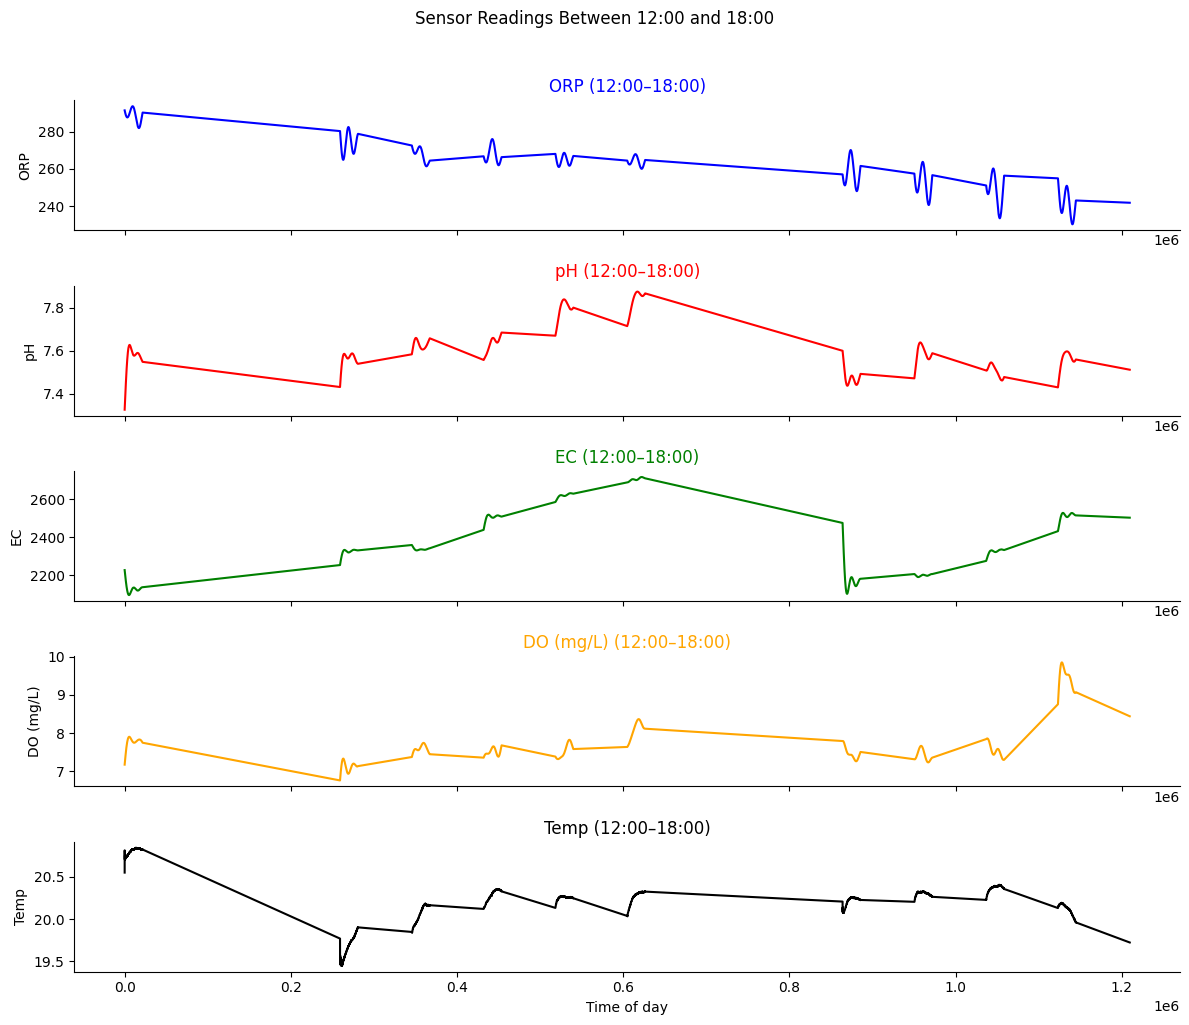

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics            import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing      import StandardScaler
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function  import Polynomial
from sysidentpy.parameter_estimation    import LeastSquares
from sysidentpy.neural_network         import NARXNN
from sysidentpy.metrics                import root_relative_squared_error

# --- 0) Take only the first 720 timesteps of your preprocessed DataFrame ---
#df_short = merged_df.iloc[:28800].copy()

sensor_cols = [
    'ORP',
    'pH',
    'EC',
    'DO (mg/L)',
    'Temp'
]

# --- 1) Extract raw exogenous inputs & target output ---
exog_cols   = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor      = 'ORP'

# create subplots for each sensor
ixarr = df_final[sensor_cols].plot(subplots=True, figsize=(12, 10), legend=False)

for ax, col in zip(ixarr, sensor_cols):
    line = ax.get_lines()[0]
    line.set_color(sensor_colors[col])
    ax.set_title(f"{col} (12:00–18:00)", color=sensor_colors[col])
    ax.set_xlabel("Time of day")
    ax.set_ylabel(col)

plt.suptitle("Sensor Readings Between 12:00 and 18:00", y=1.02)
plt.tight_layout()
plt.show()






In [ ]:
X_raw = df_final[exog_cols].values       # shape (720, 4)
y_raw = df_final[[sensor]].values        # shape (720, 1)

# --- 2) Train/test split (80/20 by time) ---
split     = int(0.8 * len(X_raw))
X_train   = X_raw[:split]
X_test    = X_raw[split:]
y_train   = y_raw[:split]
y_test    = y_raw[split:]

# ----------------------------------------------------
# 3a) Polynomial NARX via FROLS
# ----------------------------------------------------
n_lags_y    = 3
n_lags_u    = 3
poly_degree = 2
n_info      = 200


# build nested xlag for 4 exogenous inputs
xlag = [list(range(1, n_lags_u + 1)) for _ in exog_cols]



model_poly = FROLS(
    ylag           = n_lags_y,
    xlag           = xlag,
    basis_function = Polynomial(degree=poly_degree),
    estimator      = LeastSquares(),
    info_criteria  = 'aic',
    # n_info_values  = n_info,
    #err_tol=0.9996,
    #n_terms=40,
    #order_selection=False
)

# fit on raw exog + output
model_poly.fit(X=X_train, y=y_train)

# one‐step‐ahead and free‐run forecasts on test set
yhat_poly_1   = model_poly.predict(X=X_test, y=y_test, steps_ahead=1)
yhat_poly_inf = model_poly.predict(X=X_test, y=y_test)

# align & evaluate (drop warm‐up)
warmup = model_poly.max_lag
y_true = y_test[warmup:].flatten()
poly_1 = yhat_poly_1[warmup:].flatten()
poly_inf = yhat_poly_inf[warmup:].flatten()

#--------

# one‐step‐ahead (still uses true y)
yhat_poly_1 = model_poly.predict(X=X_test, y=y_test, steps_ahead=1)

# free‐run infinite‐horizon: omit y
yhat_poly_inf = model_poly.predict(X=X_test)

# now drop the warmup and flatten
warmup = model_poly.max_lag
y_true     = y_test[warmup:].flatten()
poly_inf   = yhat_poly_inf[warmup:].flatten()

# sanity‐check
print("NaNs in free‐run:", np.isnan(poly_inf).sum())

# compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f"Free‐run MAE: {mean_absolute_error(y_true, poly_inf):.4f}")
print(f"     RMSE: {np.sqrt(mean_squared_error(y_true, poly_inf)):.4f}")
print(f"       R²: {r2_score(y_true, poly_inf):.4f}")



#-----
print("y_true shape:", y_true.shape)
print("poly_inf shape:", poly_inf.shape)
print("poly_inf NaNs:", np.isnan(poly_inf).sum())

print("=== Polynomial NARX on first 720 samples (lags=200) ===")
print(f"1-step MAE: {mean_absolute_error(y_true, poly_1):.4f}")
print(f"     RMSE: {np.sqrt(mean_squared_error(y_true, poly_1)):.4f}")
print(f"       R²: {r2_score(y_true, poly_1):.4f}")
# print(f"Free-run MAE: {mean_absolute_error(y_true, poly_inf):.4f}")
# print(f"     RMSE: {np.sqrt(mean_squared_error(y_true, poly_inf)):.4f}")
# print(f"       R²: {r2_score(y_true, poly_inf):.4f}")

# 1) Build a time‐axis for the test set, aligned with your warm‐up drop
times_test = df_final.index[split:]             # Time elapsed for each test sample
times_valid = times_test[warmup:]               # drop the first `warmup` points

# 2) Plot True vs. 1-step vs. Free-run
plt.figure(figsize=(12,5))
plt.plot(times_valid, y_true,   label='True ORP',   linewidth=2)
plt.plot(times_valid, poly_1,   label='1-step ŷ',    alpha=0.7)
plt.plot(times_valid, poly_inf, label='Free-run ŷ',  alpha=0.7)
plt.xlabel('Time elapsed (s)')
plt.ylabel('ORP')
plt.title('Polynomial NARX Predictions on Test Set')
plt.legend()
plt.tight_layout()
plt.show()


TypeError: FROLS.predict() missing 1 required keyword-only argument: 'y'

Text(0, 0.5, 'Information Criteria')

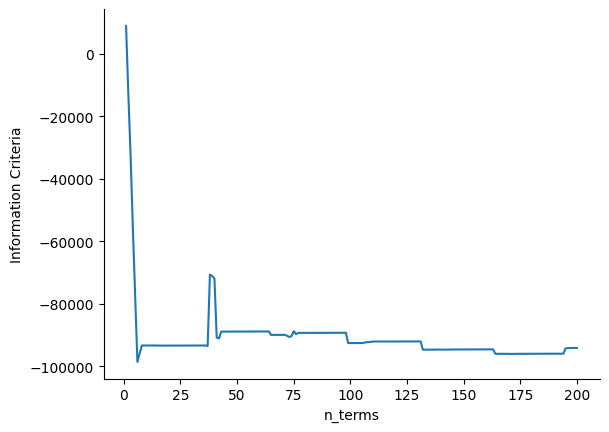

In [ ]:
xaxis = np.arange(1, model_poly.n_info_values + 1)
plt.plot(xaxis, model_poly.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")

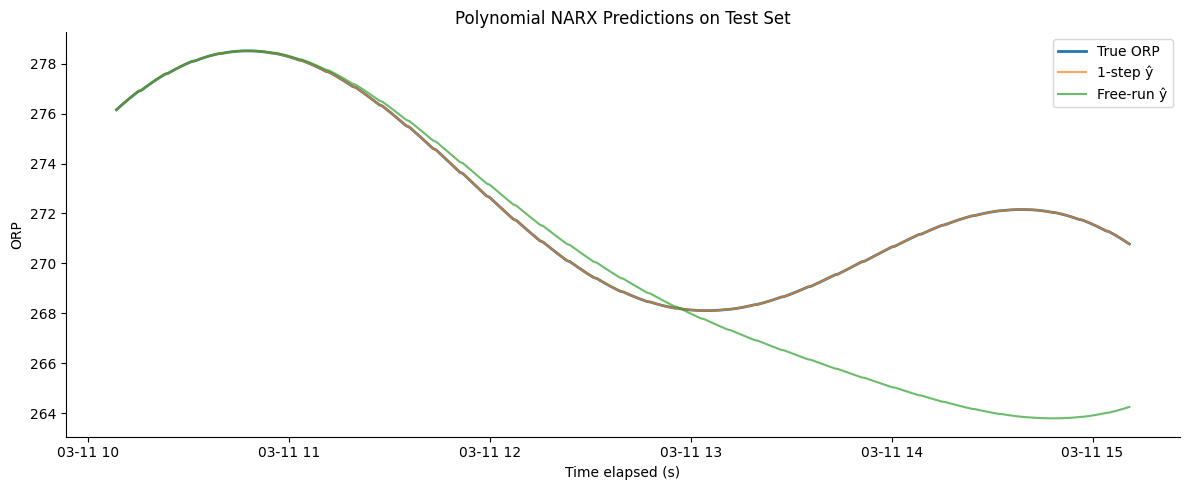

In [ ]:
# 1) Build a time‐axis for the test set, aligned with your warm‐up drop
times_test = df_short.index[split:]             # Time elapsed for each test sample
times_valid = times_test[warmup:]               # drop the first `warmup` points

# 2) Plot True vs. 1-step vs. Free-run
plt.figure(figsize=(12,5))
plt.plot(times_valid, y_true,   label='True ORP',   linewidth=2)
plt.plot(times_valid, poly_1,   label='1-step ŷ',    alpha=0.7)
plt.plot(times_valid, poly_inf, label='Free-run ŷ',  alpha=0.7)
plt.xlabel('Time elapsed (s)')
plt.ylabel('ORP')
plt.title('Polynomial NARX Predictions on Test Set')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics       import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function import Polynomial

# 0) take only the first 720 timesteps
exog_cols = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor    = 'ORP'

X_raw = merged_df[exog_cols].values    # (720,4)
y_raw = merged_df[[sensor]].values     # (720,1)

# 1) train/test split (80/20)
split   = int(0.8 * len(X_raw))
X_train = X_raw[:split];  y_train = y_raw[:split]
X_test  = X_raw[split:];  y_test  = y_raw[split:]

# 2) scale exogenous inputs
scaler = StandardScaler().fit(X_train)
Xtr_s  = scaler.transform(X_train)
Xte_s  = scaler.transform(X_test)

# 3) define a small MLP backbone
class MLP_NARX(nn.Module):
    def __init__(self, input_size, hidden_sizes=[20,10]):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.Tanh()]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# 4) lags and compute true input dimension
n_lags_y, n_lags_u = 5, 5
n_exogs            = len(exog_cols)
input_size         = n_lags_y + n_lags_u * n_exogs  # 5 + 5*4 = 25

# build nested xlag: one [1..5] list per exogenous channel
xlag = [list(range(1, n_lags_u+1)) for _ in range(n_exogs)]

# 5) instantiate Neural‐NARX
narx_net = NARXNN(
    net            = MLP_NARX(input_size=input_size, hidden_sizes=[20,10]),
    ylag           = n_lags_y,
    xlag           = xlag,
    model_type     = "NARMAX",      # exogenous + autoreg inputs
    basis_function = Polynomial(degree=1),
    loss_func      = 'mse_loss',
    optimizer      = 'Adam',
    epochs         = 2000,
    verbose        = False,
    optim_params   = {'betas': (0.9,0.999), 'eps':1e-5}
)

# 6) fit & predict
narx_net.fit(X=Xtr_s, y=y_train)  # y_train is (N,1), not ravelled

# one-step-ahead
yhat_1   = narx_net.predict(X=Xte_s, y=y_test, steps_ahead=1).reshape(-1,1)
# free-run
yhat_inf = narx_net.predict(X=Xte_s, y=y_test).reshape(-1,1)

# 7) drop warm-up and evaluate
warmup      = narx_net.max_lag
times_test  = df_short.index[split:]
times_valid = times_test[warmup:]

y_true   = y_test[warmup:].flatten()
pred1    = yhat_1[warmup:].flatten()
pred_inf = yhat_inf[warmup:].flatten()

print("=== Neural NARXNN on first 720 samples ===")
print(f"1‐step  MAE: {mean_absolute_error(y_true, pred1):.4f}")
print(f"        RMSE: {np.sqrt(mean_squared_error(y_true, pred1)):.4f}")
print(f"          R²: {r2_score(y_true, pred1):.4f}")
print(f"Free‐run MAE: {mean_absolute_error(y_true, pred_inf):.4f}")
print(f"        RMSE: {np.sqrt(mean_squared_error(y_true, pred_inf)):.4f}")
print(f"          R²: {r2_score(y_true, pred_inf):.4f}")

# 8) plot
plt.figure(figsize=(12,5))
plt.plot(times_valid, y_true,   label='True ORP',  linewidth=2)
plt.plot(times_valid, pred1,    label='1-step ŷ',   alpha=0.7)
plt.plot(times_valid, pred_inf, label='Free-run ŷ', alpha=0.7)
plt.xlabel('Time elapsed (s)')
plt.ylabel('ORP')
plt.title('Neural NARXNN Predictions on Test Set')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0115 - val_loss: 2.0029e-04
Epoch 2/5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0015 - val_loss: 1.8737e-04
Epoch 3/5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.3888e-04 - val_loss: 1.6106e-04
Epoch 4/5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6.1202e-04 - val_loss: 1.7285e-04
Epoch 5/5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 5.8006e-04 - val_loss: 1.4128e-04
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test MSE: 82.4270, R2: 0.9931


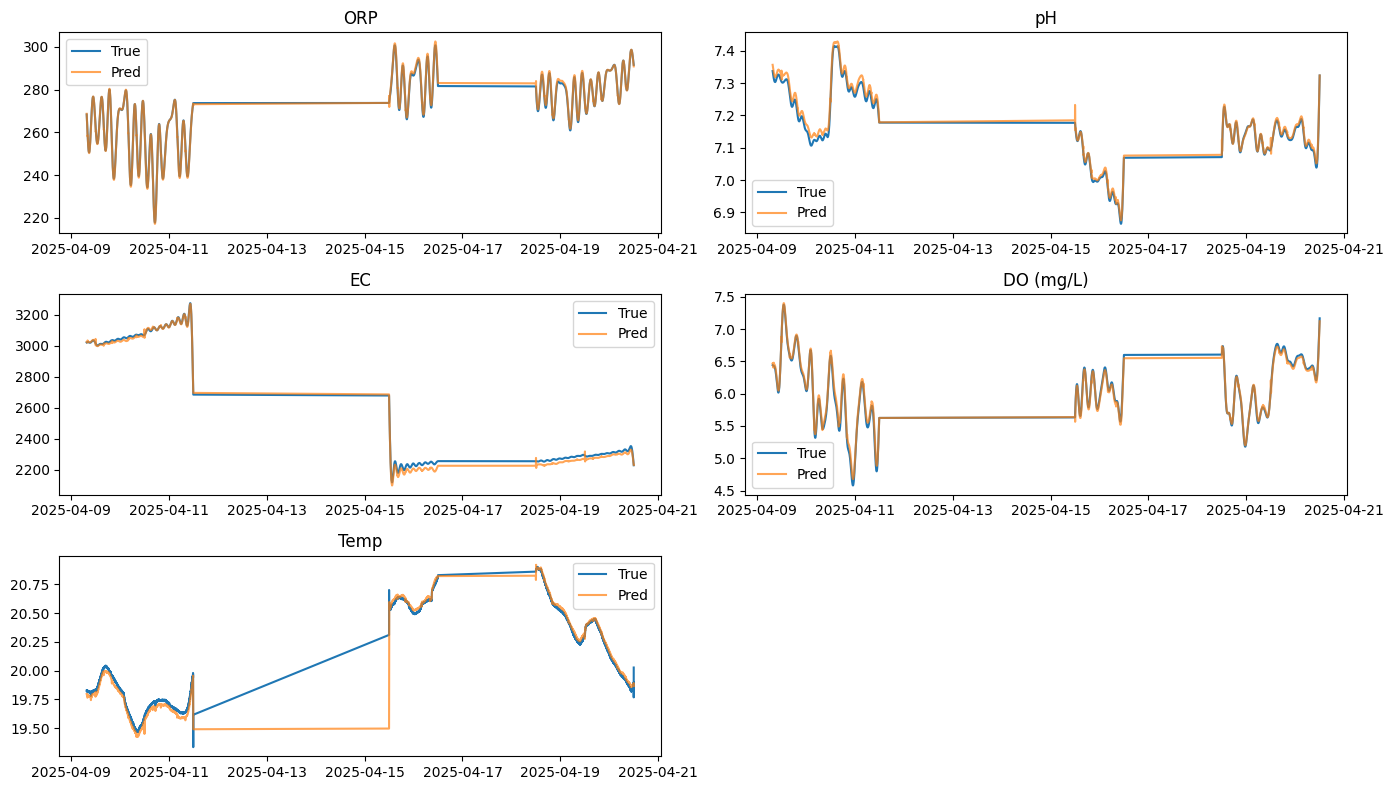

In [ ]:
exog_cols = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor_cols = ['ORP','pH','EC','DO (mg/L)','Temp']

# 2) Scale features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(merged_df[exog_cols + sensor_cols])

# 3) Create sliding windows
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :])
        y.append(data[i + window_size, len(exog_cols):])  # sensors only
    return np.array(X), np.array(y)

window_size = 30  # e.g., 30 timesteps
X, y = create_sequences(data_scaled, window_size)

# 4) Train/test split (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5) Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, X.shape[-1])),
    Dropout(0.2),
    Dense(len(sensor_cols), activation='linear')
])
model.compile(optimizer='adam', loss='mse')

# 6) Train
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# 7) Predict
y_pred = model.predict(X_test)

# 8) Invert scaling for sensors only
# Build a dummy array to inverse transform
def invert_sensors(scaled_vals, contexts):
    inv = []
    for i, sv in enumerate(scaled_vals):
        ctx = contexts[i].copy()
        ctx[-len(sensor_cols):] = sv
        inv.append(ctx)
    inv = scaler.inverse_transform(np.array(inv))
    return inv[:, -len(sensor_cols):]

# contexts = last row of each input window
contexts = X_test[:, -1, :]
y_test_inv = invert_sensors(y_test, contexts)
y_pred_inv = invert_sensors(y_pred, contexts)

# 9) Evaluate
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv, multioutput='uniform_average')
print(f"Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 10) Plot actual vs predicted for each sensor
time_axis = df.index[window_size + split : window_size + split + len(y_test_inv)]
plt.figure(figsize=(14, 8))
for i, col in enumerate(sensor_cols):
    plt.subplot(3, 2, i+1)
    plt.plot(time_axis, y_test_inv[:, i], label='True')
    plt.plot(time_axis, y_pred_inv[:, i], label='Pred', alpha=0.7)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
import matplotlib.pyplot as plt

# 1) Full dataset (~69k samples)
df = merged_df.copy()
exog_cols = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor_cols = ['ORP','pH','EC','DO (mg/L)','Temp']

# 2) Separate scaling for exogenous inputs and sensors
scaler_exog = MinMaxScaler()
scaled_exog = scaler_exog.fit_transform(df[exog_cols])
scaler_sens = MinMaxScaler()
scaled_sens = scaler_sens.fit_transform(df[sensor_cols])

# Combine into one array for sequence building
data_scaled = np.hstack([scaled_exog, scaled_sens])

# 3) Create multi-step sequences
def create_multistep(data, window_size, horizon, n_exogs):
    X, Y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i : i + window_size, :])               # exog + sensors history
        Y.append(data[i + window_size : i + window_size + horizon, n_exogs:])  # future sensors
    return np.array(X), np.array(Y)

W = 480    # look-back window (60 samples)
H = 120   # forecast horizon (120 samples)
X, Y = create_multistep(data_scaled, W, H, len(exog_cols))

# 4) Train/test split (80/20 by time)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# 5) Build Seq2Seq LSTM model
model = Sequential([
    LSTM(8, input_shape=(W, X.shape[-1])),
    Dropout(0.2),
    RepeatVector(H),
    TimeDistributed(Dense(len(sensor_cols)))
])
model.compile(optimizer='adam', loss='mse')

# 6) Train
history = model.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# 7) Predict multi-step
Y_pred_scaled = model.predict(X_test)




Epoch 1/3
390/390 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.1188 - val_loss: 0.0197
Epoch 2/3
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0206 - val_loss: 0.0118
Epoch 3/3
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0115 - val_loss: 0.0053
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


ORP RMSE over 120-step forecast: 11.897
pH RMSE over 120-step forecast: 0.186
EC RMSE over 120-step forecast: 83.792
DO (mg/L) RMSE over 120-step forecast: 0.500
Temp RMSE over 120-step forecast: 0.216


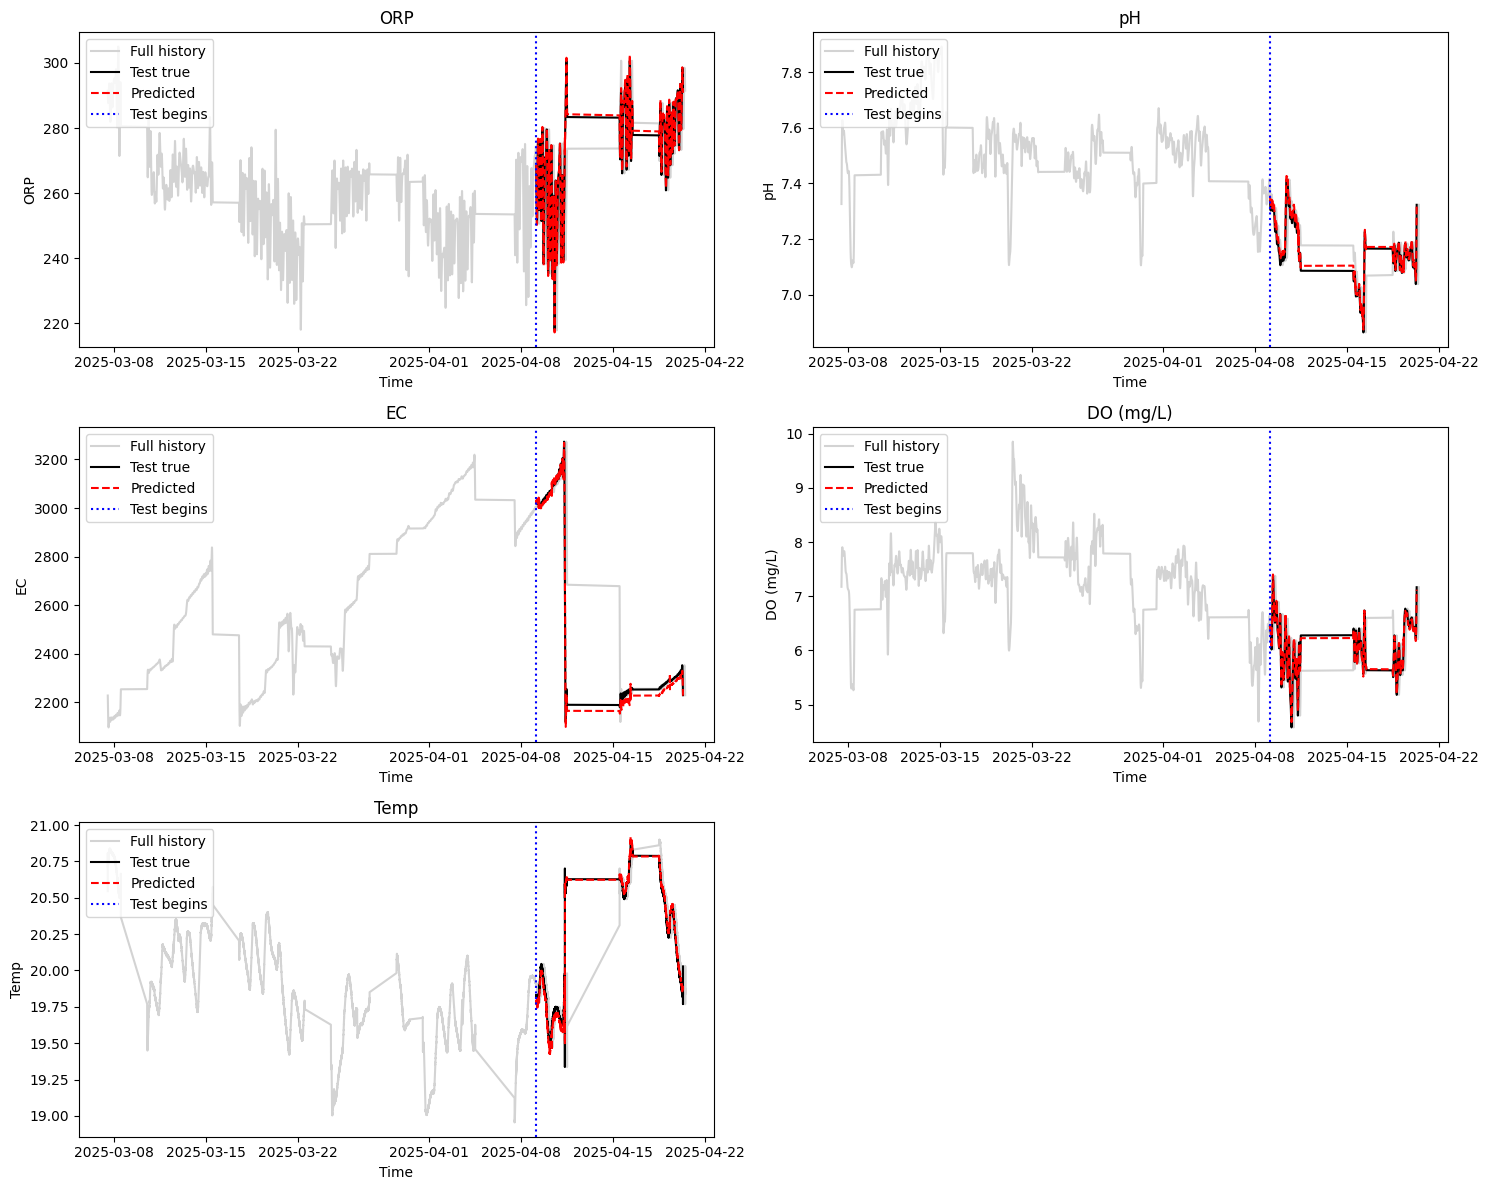

In [ ]:


# 8) Invert scaling for sensors
# Reshape to 2D, invert, then reshape back
n_test = Y_test.shape[0]
Y_test_flat = Y_test.reshape(-1, len(sensor_cols))
Y_pred_flat = Y_pred_scaled.reshape(-1, len(sensor_cols))

Y_test_inv = scaler_sens.inverse_transform(Y_test_flat).reshape(n_test, H, len(sensor_cols))
Y_pred_inv = scaler_sens.inverse_transform(Y_pred_flat).reshape(n_test, H, len(sensor_cols))

# 9) Evaluate RMSE at each horizon step for each sensor, then average
# --- 9b) Compute RMSE per sensor over the entire H-step horizon ---
for i, col in enumerate(sensor_cols):
    # MSE over all windows and all steps of the horizon
    mse_i = ((Y_test_inv[:,:,i] - Y_pred_inv[:,:,i])**2).mean()
    rmse_i = np.sqrt(mse_i)
    print(f"{col} RMSE over {H}-step forecast: {rmse_i:.3f}")



# --- assume you have: ---
# merged_df      : full DataFrame, index = datetime, columns include sensor_cols
# sensor_cols    = ['ORP','pH','EC','DO (mg/L)','Temp']
# window_size    = W   # e.g. 60
# H              = horizon if multi-step, or 1 for one-step
# split          = index into sequences where test begins
# y_test_inv     : shape (n_test, len(sensor_cols)) for one-step
# y_pred_inv     : same shape as y_test_inv

# 1) full time axis
full_times = merged_df.index

# 2) test‐set time axis (for one-step, simply from the first test prediction onward)
test_start_idx = window_size + split
test_times     = merged_df.index[test_start_idx : test_start_idx + len(y_test_inv)]

plt.figure(figsize=(15,12))

for i, col in enumerate(sensor_cols):
    ax = plt.subplot(3, 2, i+1)

    # a) full history in light gray
    ax.plot(full_times, merged_df[col], color='lightgray', label='Full history')

    # b) true test values in black
    ax.plot(test_times, y_test_inv[:, i], color='black', label='Test true')

    # c) predicted test values in red dashed
    ax.plot(test_times, y_pred_inv[:, i], color='red', linestyle='--', label='Predicted')

    # d) vertical line at test-start
    ax.axvline(full_times[test_start_idx], color='blue', linestyle=':', label='Test begins')

    ax.set_title(col)
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0176
Epoch 2/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0022
Epoch 3/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0014
Epoch 4/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 9.1454e-04
Epoch 5/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.5317e-04
Epoch 6/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.3615e-04
Epoch 7/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.4260e-04
Epoch 8/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.3531e-04
Epoch 9/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.3498e-04
Epoch 10/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.2241e-04
Epoch 11/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.2831e-04
Epoch 12/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.1701e-04
Epoch 13/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.2295e-04
Epoch 14/20
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - lo

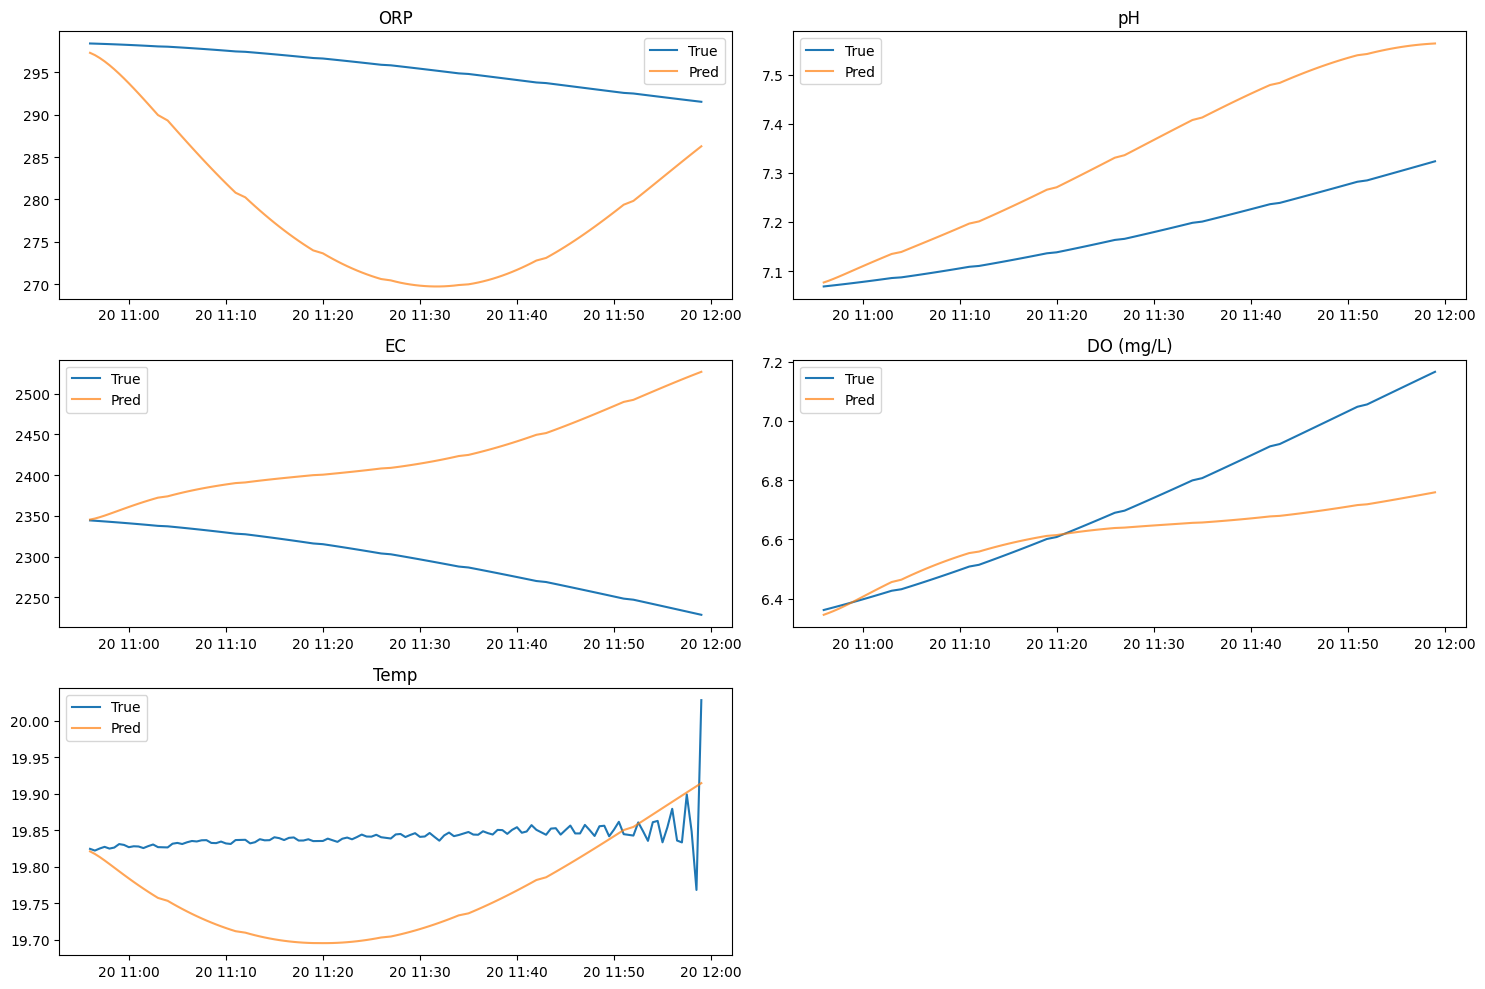

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Parameters
W = 60   # look-back window (samples)
H = 120  # horizon to forecast

# 1) Split off the horizon
df = merged_df.copy()
exog_cols = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor_cols = ['ORP','pH','EC','DO (mg/L)','Temp']

train_df = df.iloc[:-H]
horizon_df = df.iloc[-H:]  # will be ground truth

# 2) Scale exog and sensor separately
scaler_ex = MinMaxScaler().fit(train_df[exog_cols])
scaler_sy = MinMaxScaler().fit(train_df[sensor_cols])

train_ex = scaler_ex.transform(train_df[exog_cols].values)
train_sy = scaler_sy.transform(train_df[sensor_cols].values)
horizon_ex = scaler_ex.transform(horizon_df[exog_cols].values)
horizon_sy = scaler_sy.transform(horizon_df[sensor_cols].values)

# Combine for training sequences
train_data = np.hstack([train_ex, train_sy])

# 3) Build one-step sequences on train_data
def create_1step(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])
        y.append(data[i+window, len(exog_cols):])  # next sensors
    return np.array(X), np.array(y)

X_train, y_train = create_1step(train_data, W)

# 4) Train a one-step LSTM
model = Sequential([
    LSTM(64, input_shape=(W, X_train.shape[-1])),
    Dropout(0.2),
    Dense(len(sensor_cols))
])
model.compile('adam', 'mse')
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

# 5) Recursive forecast over horizon
# Seed history with last W rows of train_data
history = train_data[-W:].copy()
preds = []
for i in range(H):
    inp = history[-W:].reshape(1, W, -1)
    yhat = model.predict(inp, verbose=0)[0]  # scaled sensor vector
    preds.append(yhat)
    # append new row: [horizon_exog[i], yhat]
    new_row = np.hstack([horizon_ex[i], yhat])
    history = np.vstack([history, new_row])

preds = np.array(preds)  # shape (H, n_sensors)

# 6) Invert scaling to original sensor units
preds_inv = scaler_sy.inverse_transform(preds)
true_inv  = scaler_sy.inverse_transform(horizon_sy)

# 7) Compute RMSE per sensor
for i, col in enumerate(sensor_cols):
    rmse = np.sqrt(mean_squared_error(true_inv[:, i], preds_inv[:, i]))
    print(f"{col} RMSE over horizon: {rmse:.3f}")

# 8) Plot true vs predicted for horizon
time_axis = horizon_df.index
plt.figure(figsize=(15,10))
for i, col in enumerate(sensor_cols):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(time_axis, true_inv[:, i], label='True')
    ax.plot(time_axis, preds_inv[:, i], label='Pred', alpha=0.7)
    ax.set_title(col)
    ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics        import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

# 1) Parameters
H = 120  # forecast horizon
exo_cols   = ['feed_effect','bicarbonate_effect','salt_effect','flowrate_effect']
sensor_cols= ['ORP','pH','EC','DO (mg/L)','Temp']

# 2) Split off the horizon
df         = merged_df.copy()
train_df   = df.iloc[:-H]
horizon_df = df.iloc[-H:]

# 3) Extract & scale
exo_all      = df[exo_cols].values
sen_train    = train_df[sensor_cols].values
horizon_exo  = horizon_df[exo_cols].values
horizon_sens = horizon_df[sensor_cols].values

scaler_exo   = MinMaxScaler().fit(exo_all)
scaler_sen   = MinMaxScaler().fit(sen_train)

exo_all_s      = scaler_exo.transform(exo_all)
sen_train_s    = scaler_sen.transform(sen_train)
horizon_exo_s  = scaler_exo.transform(horizon_exo)
horizon_sens_s = scaler_sen.transform(horizon_sens)

# 4) Build Seq2Seq training windows
seq_len = 2*H + 1
n_exog  = len(exo_cols)
n_sens  = len(sensor_cols)

X_train, Y_train = [], []
# STOP at len(train_df) - H so that i+1+H never exceeds train_df length
for i in range(H, len(train_df) - H):
    # exo window: [i-H ... i+H]
    exo_win = exo_all_s[i-H : i+H+1]             # (2H+1, n_exog)
    # sensor past window: [i-H ... i]
    sen_win = sen_train_s[i-H : i+1]             # (H+1, n_sens)
    # pad zeros for future sensor positions to align seq_len
    pad_win = np.zeros((H, n_sens))
    sen_pad = np.vstack([sen_win, pad_win])      # (2H+1, n_sens)

    # stack horizontally exo and sensor history
    X_train.append(np.hstack([exo_win, sen_pad]))  # (2H+1, n_exog+n_sens)

    # target: true sensors [i+1 ... i+H]
    Y_train.append(sen_train_s[i+1 : i+1+H])        # (H, n_sens)

X_train = np.stack(X_train)   # (N_windows, 2H+1, n_exog+n_sens)
Y_train = np.stack(Y_train)   # (N_windows, H, n_sens)

# 5) Build & compile the Seq2Seq LSTM
model = Sequential([
    LSTM(256, input_shape=(seq_len, n_exog+n_sens)),
    Dropout(0.2),
    RepeatVector(H),
    LSTM(128, return_sequences=True),
    Dense(256, activation='relu'),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(n_sens))
])
model.compile(optimizer='adam', loss='mse')

# 6) Train
model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

# 7) Forecast the held-out horizon
i0       = len(train_df) - H - 1  # last index we used in training loop
exo_win0 = exo_all_s[i0-H : i0+H+1]
sen_win0 = sen_train_s[i0-H : i0+1]
pad0     = np.zeros((H, n_sens))
X0       = np.expand_dims(np.hstack([exo_win0, np.vstack([sen_win0, pad0])]), axis=0)

Y_pred_s = model.predict(X0)[0]    # (H, n_sens)

# 8) Invert scaling
Y_pred = scaler_sen.inverse_transform(Y_pred_s)
Y_true = horizon_sens  # raw sensor horizon

# 9) Compute RMSE per sensor
for j, col in enumerate(sensor_cols):
    rmse = np.sqrt(mean_squared_error(Y_true[:,j], Y_pred[:,j]))
    print(f"{col} RMSE over horizon: {rmse:.3f}")

# 10) Plot
plt.figure(figsize=(15,10))
for j, col in enumerate(sensor_cols):
    ax = plt.subplot(3,2,j+1)
    ax.plot(horizon_df.index, Y_true[:,j], label='True')
    ax.plot(horizon_df.index, Y_pred[:,j], label='Pred', alpha=0.7)
    ax.set_title(col)
    ax.legend()
plt.tight_layout()
plt.show()


Epoch 1/20
396/979 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0548

KeyboardInterrupt: 